In [4]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error

from matplotlib import pyplot as plt

class NNetRegressor(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        model_class,
        loss=nn.MSELoss(),
        optimizer_class=optim.Adam,
        optimizer_params={},
        epochs=100,
        batch_size=32,
        learning_rate=0.001,
        device="cpu",
        metrics={"mse": mean_squared_error},
        val_set=None,
        verbose=False,
    ):
        self.model_class = model_class
        self.loss = loss
        self.optimizer_class = optimizer_class
        self.optimizer_params = optimizer_params
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.metrics = metrics
        self.val_set = val_set
        self.device = device
        self.verbose = verbose
        self.train_loss = []
        self.val_loss = []
        self.train_metrics = {k: [] for k, _ in metrics.items()}
        self.val_metrics = {k: [] for k, _ in metrics.items()}

    def on_train_start(self, X, y):
        self.model = self.model_class(input_size=X.shape[1])
        self.model.to(self.device)
        self.model.train()
        self.optimizer = self.optimizer_class(
            self.model.parameters(), lr=self.learning_rate, **self.optimizer_params
        )

    def on_train_end(self):
        pass

    def on_epoch_start(self, epoch):
        pass

    def on_epoch_end(self, epoch, X, y):
        self.evaluate(X, y)
        if self.val_set:
            X_val, y_val = self.tensorify(*self.val_set)
            self.evaluate(X_val, y_val, is_train=False)

        if self.verbose and epoch % 10 == 0:
            msg = f"Epoch {epoch + 1}/{self.epochs}"
            msg += f" - Loss: {self.train_loss[-1]:.4f}"
            msg += f" - Train metrics: {', '.join([f'{name}: {evals[-1]:.4f}' for name, evals in self.train_metrics.items()])}"
            if self.val_set:
                msg += f" - Val Loss: {self.val_loss[-1]:.4f}"
                msg += f" - Val Metrics: {', '.join([f'{name}: {evals[-1]:.4f}' for name, evals in self.val_metrics.items()])}"
            print(msg)

    def evaluate(self, X, y, is_train=True):
        X, y = self.tensorify(X, y)
        self.model.eval()
        sset = ("train" if is_train else "val")

        with torch.no_grad():
            preds = self.model(X)
            loss = self.loss(preds, y).item()
            getattr(self, sset + "_loss").append(loss)

            y_np = y.cpu().numpy()
            preds_np = preds.cpu().numpy()
            for name, metric in self.metrics.items():
                getattr(self, sset + "_metrics")[name].append(metric(y_np, preds_np))

    def train_step(self, X_batch, y_batch):
        self.optimizer.zero_grad()
        preds = self.model(X_batch)
        loss = self.loss(preds, y_batch)
        loss.backward()
        self.optimizer.step()

    def tensorify(self, X, y=None):
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, dtype=torch.float32).to(self.device)
        if y is not None:
            if not isinstance(y, torch.Tensor):
                y = torch.tensor(y, dtype=torch.float32).to(self.device)
            return X, y
        else:
            return y

    def fit(self, X, y):
        X, y = self.tensorify(X, y)
        dataloader = DataLoader(
            TensorDataset(X, y), batch_size=self.batch_size, shuffle=True
        )

        self.on_train_start(X, y)
        for epoch in range(self.epochs):
            self.on_epoch_start(epoch)
            for batch_X, batch_y in dataloader:
                self.train_step(batch_X, batch_y)
            self.on_epoch_end(epoch, X, y)
        self.on_train_end()

        return self

    def predict(self, X):
        X = self.tensorify(X)
        self.model.eval()
        with torch.no_grad():
            predictions = self.model(X).cpu().numpy()
        return predictions

    def plot_loss(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_loss, label="Training Loss")
        if self.val_set:
            plt.plot(self.val_loss, label="Validation Loss")
        plt.title("Loss Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

    def plot_metrics(self):
        for name, _ in self.metrics.items():
            plt.figure(figsize=(10, 5))
            plt.plot(self.train_metrics[name], label=f"Training {name.upper()}")
            if self.val_set:
                plt.plot(self.val_metrics[name], label=f"Validation {name.upper()}")
            plt.title(f"{name.upper()} Over Epochs")
            plt.xlabel("Epoch")
            plt.ylabel(name.upper())
            plt.legend()
            plt.show()

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, HalvingRandomSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import Ridge

import warnings
# from reg import NNetRegressor

pd.options.display.max_columns = None
warnings.filterwarnings("ignore")
%matplotlib inline

## Data

In [7]:
train_data = pd.read_csv('data/house_prices_train.csv')
test_data = pd.read_csv('data/house_prices_test.csv')
                       
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
from ydata_profiling import ProfileReport

data_profile = ProfileReport(train_data, explorative=True)

In [11]:
# data_profile.to_widgets()
data_profile.to_file("data_profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## EDA

In [3]:
train_data.isnull().mean().sort_values(ascending=False).to_frame().T

,PoolQC,MiscFeature,Alley,Fence,MasVnrType,FireplaceQu,LotFrontage,GarageYrBlt,GarageCond,GarageType,GarageFinish,GarageQual,BsmtFinType2,BsmtExposure,BsmtQual,BsmtCond,BsmtFinType1,MasVnrArea,Electrical,Id,Functional,Fireplaces,KitchenQual,KitchenAbvGr,BedroomAbvGr,HalfBath,FullBath,BsmtHalfBath,TotRmsAbvGrd,GarageCars,GrLivArea,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,BsmtFullBath,HeatingQC,LowQualFinSF,LandSlope,OverallQual,HouseStyle,BldgType,Condition2,Condition1,Neighborhood,LotConfig,YearBuilt,Utilities,LandContour,LotShape,Street,LotArea,MSZoning,OverallCond,YearRemodAdd,2ndFlrSF,BsmtFinSF2,1stFlrSF,CentralAir,MSSubClass,Heating,TotalBsmtSF,BsmtUnfSF,BsmtFinSF1,RoofStyle,Foundation,ExterCond,ExterQual,Exterior2nd,Exterior1st,RoofMatl,SalePrice
0,0.995205,0.963014,0.937671,0.807534,0.59726,0.472603,0.177397,0.055479,0.055479,0.055479,0.055479,0.055479,0.026027,0.026027,0.025342,0.025342,0.025342,0.005479,0.000685,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


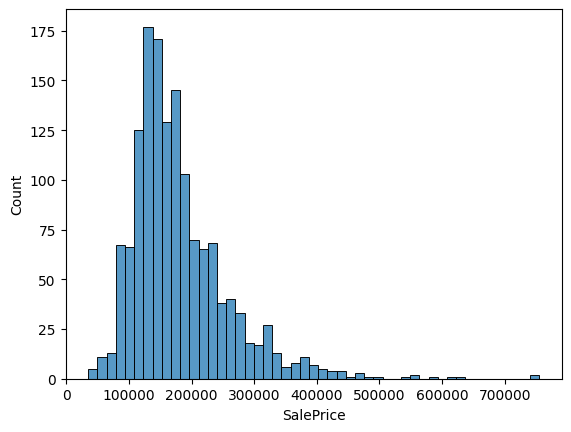

In [60]:
sns.histplot(train_data["SalePrice"])
plt.show()

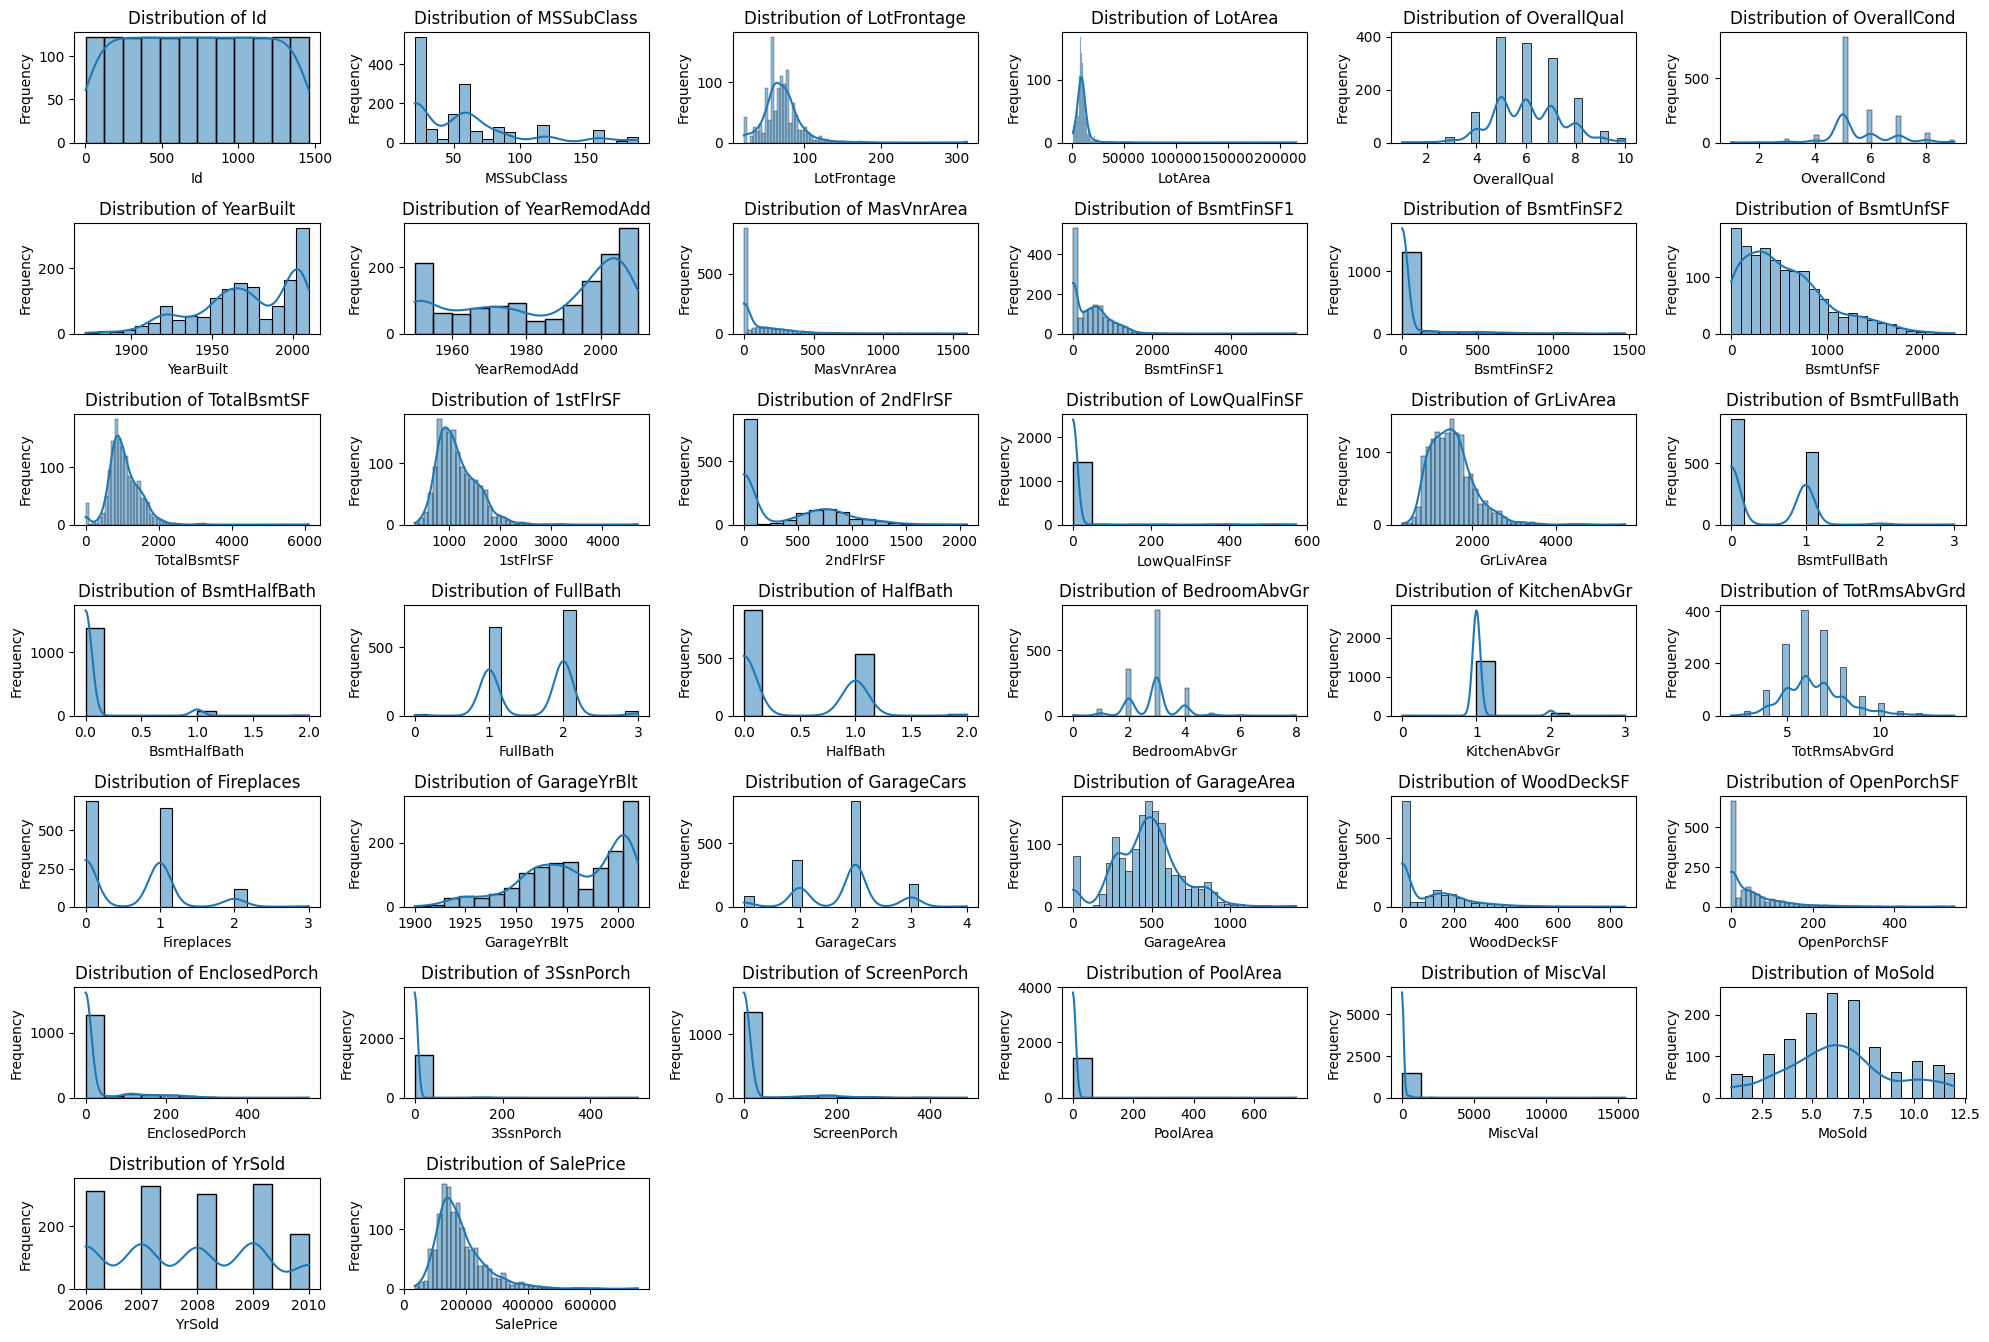

In [5]:
numeric_cols = train_data.select_dtypes(include=[np.number])
grid_size = (8, 6)  
fig, axes = plt.subplots(*grid_size, figsize=(20, 15))

for i, col_idx in enumerate(range(len(numeric_cols.columns))):  
    row, col = divmod(i, grid_size[1])
    ax = axes[row, col]
    sns.histplot(train_data[numeric_cols.columns[col_idx]], kde=True, ax=ax)  
    ax.set_title(f'Distribution of {numeric_cols.columns[col_idx]}')  
    ax.set_xlabel(numeric_cols.columns[col_idx])  
    ax.set_ylabel('Frequency')

for i in range(len(numeric_cols.columns), grid_size[0] * grid_size[1]):
    row, col = divmod(i, grid_size[1])
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()


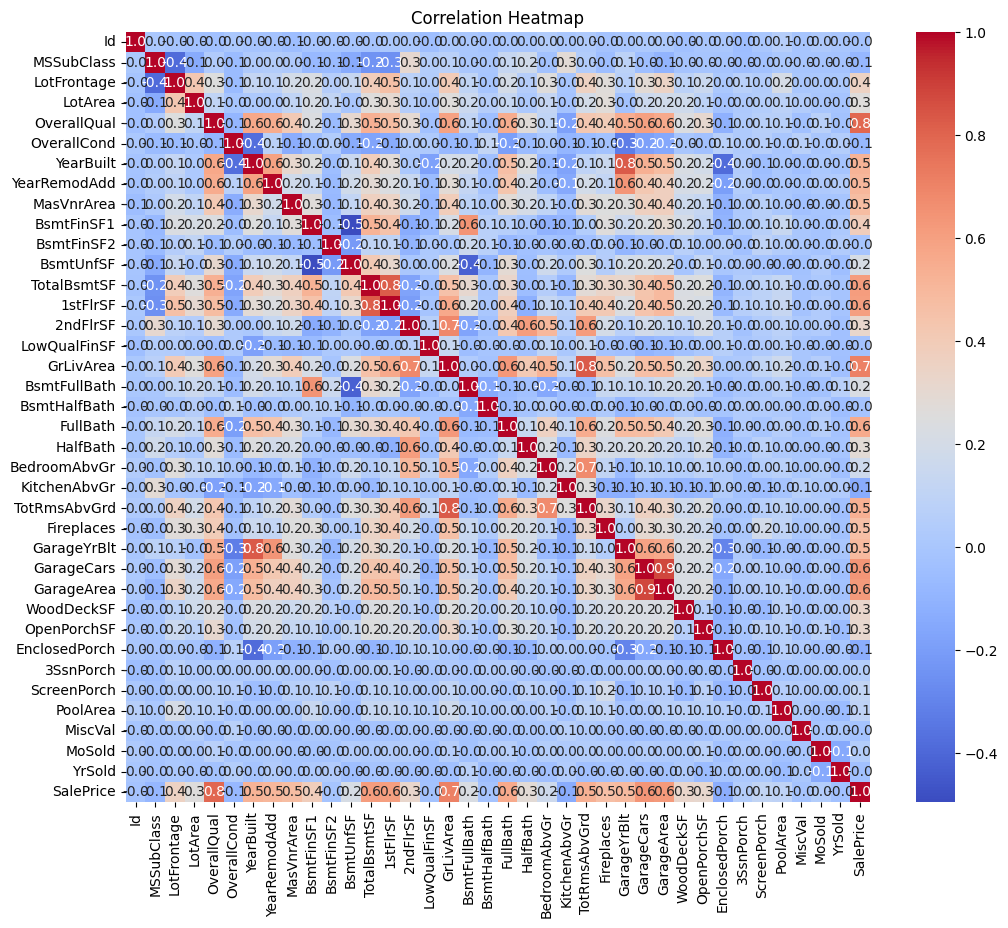

In [6]:
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt=".1f")
plt.title("Correlation Heatmap")
plt.show()

## Pipeline

In [13]:
class NullDropper(BaseEstimator, TransformerMixin):
    def __init__(self, null_threshold=0.4):
        self.null_threshold = null_threshold
    
    def fit(self, X, y=None):
        missing_proportion = X.isnull().mean()
        self.columns_to_drop_ = missing_proportion[missing_proportion > self.null_threshold].index
        return self
    
    def transform(self, X):
        return X.drop(columns=self.columns_to_drop_)

In [14]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')) 
])

imputer_encoder = ColumnTransformer(
    transformers=[
        ('num', num_transformer, selector(dtype_exclude='object')),
        # ('cat', cat_transformer, selector(dtype_include='object'))
    ]
)

pipe = Pipeline(steps=[
    ('dropper', NullDropper()),
    ('preprocessor', imputer_encoder)
])

pipe

Pipeline(steps=[('dropper', NullDropper()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x31b5154d0>)]))])

## Train val split

In [25]:
X_train, X_val, y_train, y_val = train_test_split(
    train_data.drop("SalePrice", axis=1), 
    train_data["SalePrice"],
    test_size=0.2,
    random_state=12
)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
print(type(X_train), type(X_val), type(y_train), type(y_val))

(1168, 80) (292, 80) (1168,) (292,)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [102]:
X_train_transformed = pipe.fit_transform(X_train)
X_val_transformed = pipe.transform(X_val)
y_train_transformed = np.log1p(y_train)
y_val_transformed = np.log1p(y_val)

print(X_train_transformed.shape, X_val_transformed.shape)

(1168, 37) (292, 37)


## Modeling

In [67]:
torch.cuda.is_available()

False

In [272]:
class ActivationGradientTracker:
    def __init_subclass__(cls):
        if not issubclass(cls, nn.Module):
            raise TypeError(
                f"to subclass TrailRecorder, Class {cls.__name__} must subclass from nn.Module too"
            )
        
    def tarck_intermediate_activations(self):
        def gen_activation_hook(name):
            def hook(module, input, output):
                if not hasattr(self, 'activations'):
                    self.activations = {}
                self.activations[f"{name}_activations"] = output
            return hook
        for name, child in self.named_children():
            if isinstance(child, nn.Linear):
                child.register_forward_hook(gen_activation_hook(name))
    
    def tarck_gradients(self):
        def gen_gradient_hook(name):
            def hook(module, grad_input, grad_output):
                if not hasattr(self, 'gradients'):
                    self.gradients = {}
                self.gradients[f"{name}_gradients"] = grad_output
            return hook
        for name, child in self.named_children():
            if isinstance(child, nn.Linear):
                child.register_full_backward_hook(gen_gradient_hook(name))
    

    def plot_activations(self, X, y, agg_func=torch.mean, fig_title=""):
        self.tarck_intermediate_activations()
        preds = self(X)
        num_layers = len(self.activations)
        
        fig, axs = plt.subplots(1, num_layers, figsize=(5 * (num_layers + 1), 8))
        
        for i, (name, activation) in enumerate(list(self.activations.items())[:-1]):
            agg_activation = agg_func(activation, dim=0).detach().numpy()
            axs[i].imshow(agg_activation.reshape(-1, 1), cmap='YlGn', aspect='auto')
            axs[i].set(
                title=f'{name}', 
                xlabel="", 
                ylabel="", 
                xticklabels=[],
                yticklabels=[],
            )
        
        axs[-1].scatter(y.detach().numpy(), preds.detach().numpy(), alpha=0.5, color="yellowgreen")
        axs[-1].plot(y.detach().numpy(), y.detach().numpy(), 'r--') 
        axs[-1].set(title='truth vs preds', xlabel="truth", ylabel="preds")
        
        fig.suptitle(fig_title)
        fig.tight_layout()
        fig.show()

    def plot_compared_activations(self, dataset1, dataset2, agg_func=torch.mean, fig_title1="", fig_title2=""):
        self.plot_activations(*dataset1, agg_func, fig_title=fig_title1)
        self.plot_activations(*dataset2, agg_func, fig_title=fig_title2)

    def plot_train_val_activations(self, trainset, valset, agg_func=torch.mean, bins=None):
        X_train, y_train = trainset
        X_val, y_val = valset
        if bins is None:
            bins = torch.quantile(y_train, torch.linspace(0, 1, 11))

        train_bins = torch.bucketize(y_train, bins)
        val_bins = torch.bucketize(y_val, bins)

        train_index = [torch.nonzero(train_bins == i).squeeze() for i in range(1, len(bins))]
        val_index = [torch.nonzero(val_bins == i).squeeze() for i in range(1, len(bins))]

        for i, (train_idx, val_idx) in enumerate(zip(train_index, val_index)):
            X_train_chunk, y_train_chunk = X_train[train_idx], y_train[train_idx]
            X_val_chunk, y_val_chunk = X_val[val_idx], y_val[val_idx]
            self.plot_compared_activations(
                (X_train_chunk, y_train_chunk), 
                (X_val_chunk, y_val_chunk), 
                agg_func,
                fig_title1=f"{i+1}th training set",
                fig_title2=f"{i+1}th validation set",
            )


In [273]:
class BaseNNet(nn.Module, ActivationGradientTracker):
    def __init__(self, input_size, layers=[32, 32, 8], output_size=1):
        super(BaseNNet, self).__init__()
        self.input_size = input_size
        self.layers = layers
        self.output_size = output_size
        for i in range(len(layers)):
            in_features = input_size if i == 0 else layers[i-1]
            out_features = layers[i]
            setattr(self, f"linear{i}", nn.Linear(in_features, out_features))
        self.final_linear = nn.Linear(layers[-1], output_size)
    
    def forward(self, x):
        for i in range(len(self.layers)):
            x = getattr(self, f"linear{i}")(x)
            x = nn.ReLU()(x)
        x = self.final_linear(x)
        return x

In [274]:
def train_loop(
    model:BaseNNet, 
    train_set, val_set, 
    loss_fn=nn.MSELoss(), 
    optim_class=optim.Adam, 
    epochs=100, 
    verbose=True
):
    X_train = torch.tensor(train_set[0], dtype=torch.float32)
    y_train = torch.tensor(train_set[1], dtype=torch.float32)
    X_val = torch.tensor(val_set[0], dtype=torch.float32)
    y_val = torch.tensor(val_set[1], dtype=torch.float32)


    model.train()
    model.tarck_intermediate_activations()
    model.tarck_gradients()

    optimizer = optim_class(model.parameters())
    train_losses, val_losses = [], []
    dataloader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)

    for epoch in range(epochs):
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            preds = model(batch_X)
            loss = loss_fn(preds, batch_y)
            loss.backward()
            optimizer.step()
        
        train_preds, val_preds = model(X_train), model(X_val)
        train_loss, val_loss = loss_fn(train_preds, y_train).item(), loss_fn(val_preds, y_val).item()
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if verbose:
            print(f"Epoch: {epoch}/{epochs} - Train Loss {train_loss} - Val Loss: {val_loss}")
    
    return train_losses, val_losses, model

In [275]:
_, _, model = train_loop(
    model=BaseNNet(
        input_size=X_train_transformed.shape[1],
        layers=[32, 32, 8]
    ),
    train_set=(X_train_transformed, y_train_transformed.values),
    val_set=(X_val_transformed, y_val_transformed.values),
    epochs=500,
    verbose=False,
)

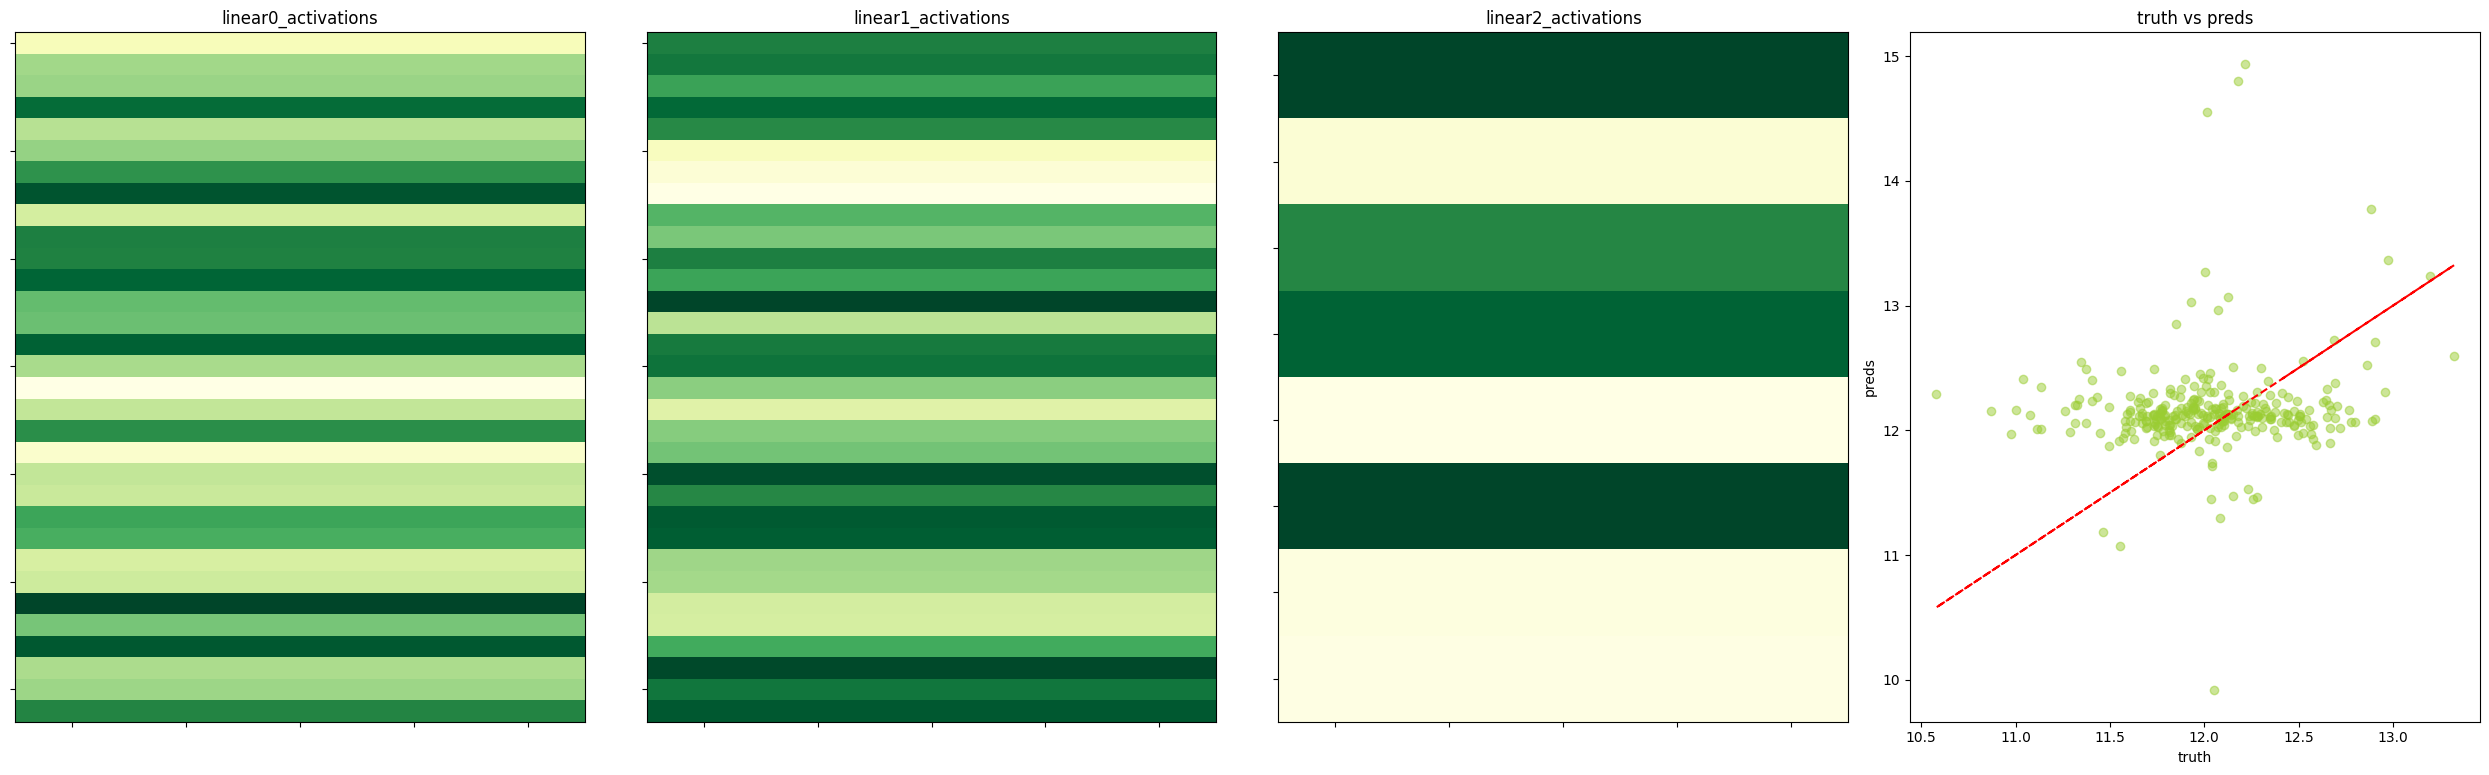

In [276]:
model.plot_activations(
    X=torch.tensor(X_val_transformed, dtype=torch.float32), 
    y=torch.tensor(y_val_transformed.values, dtype=torch.float32)
)

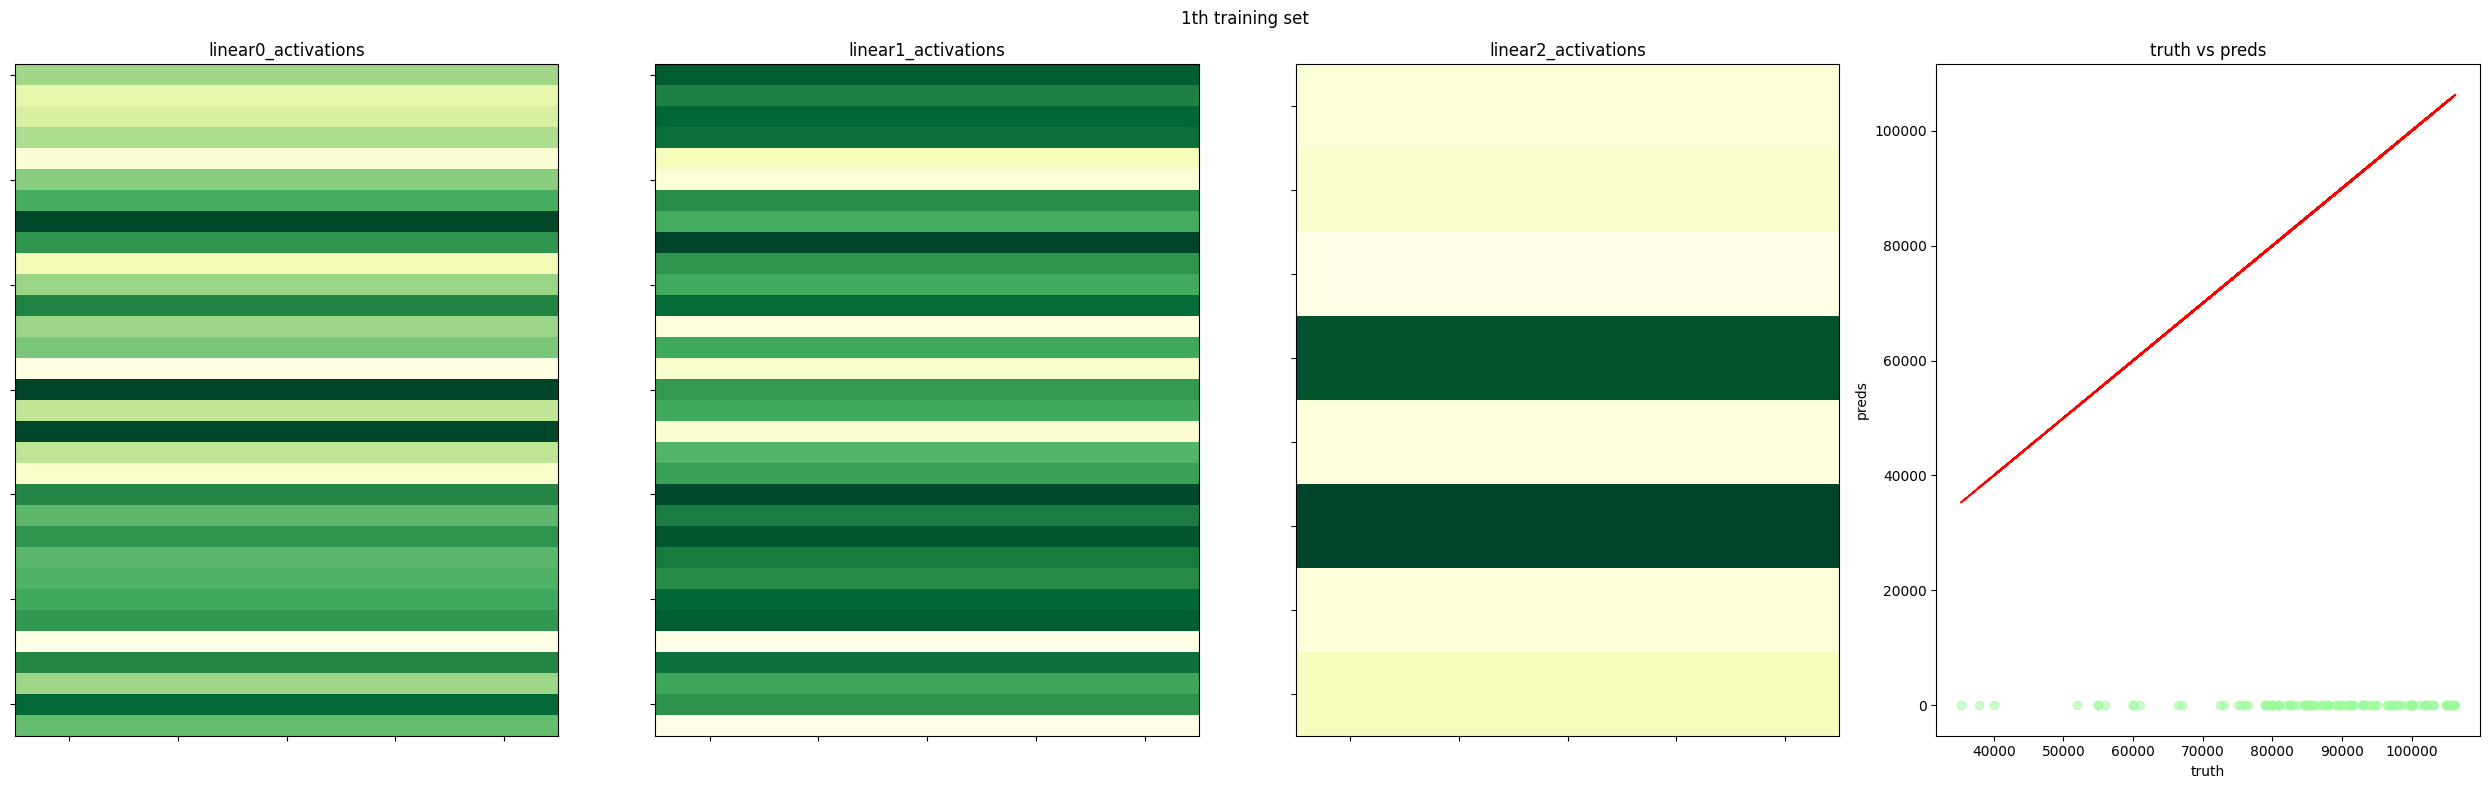

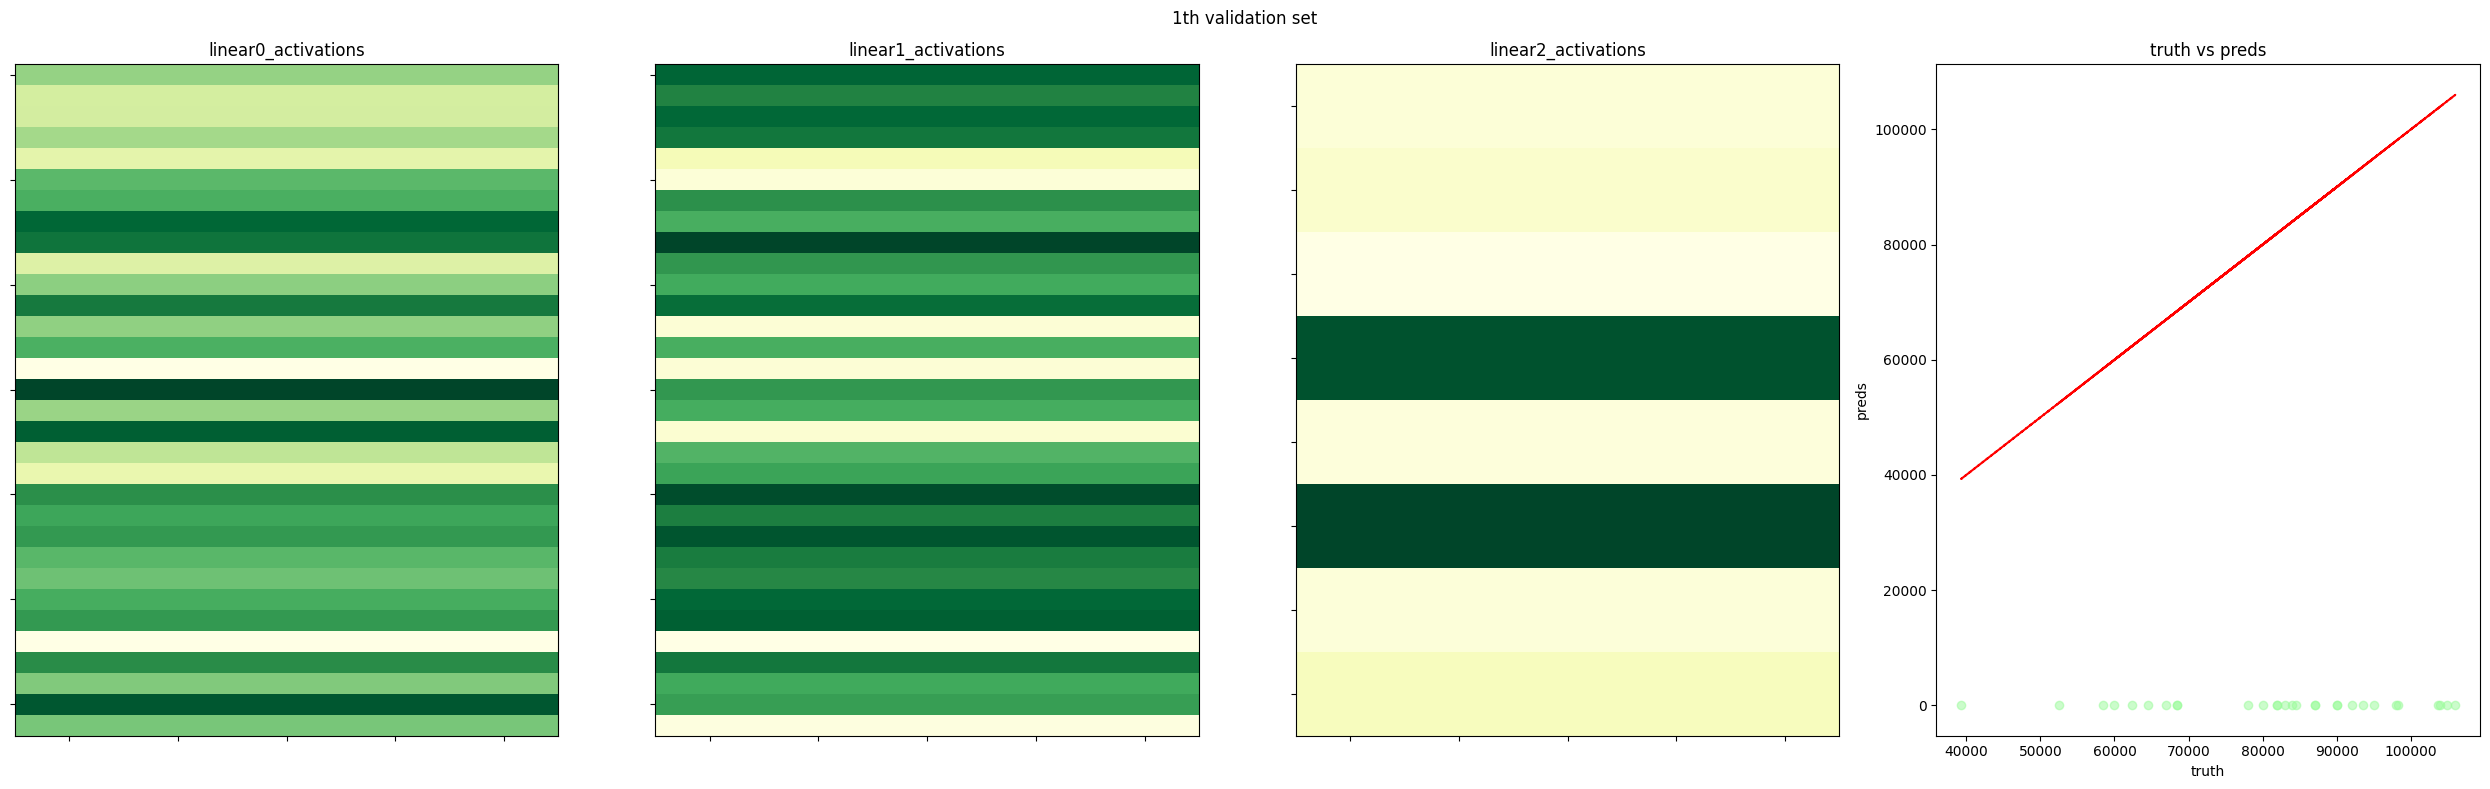

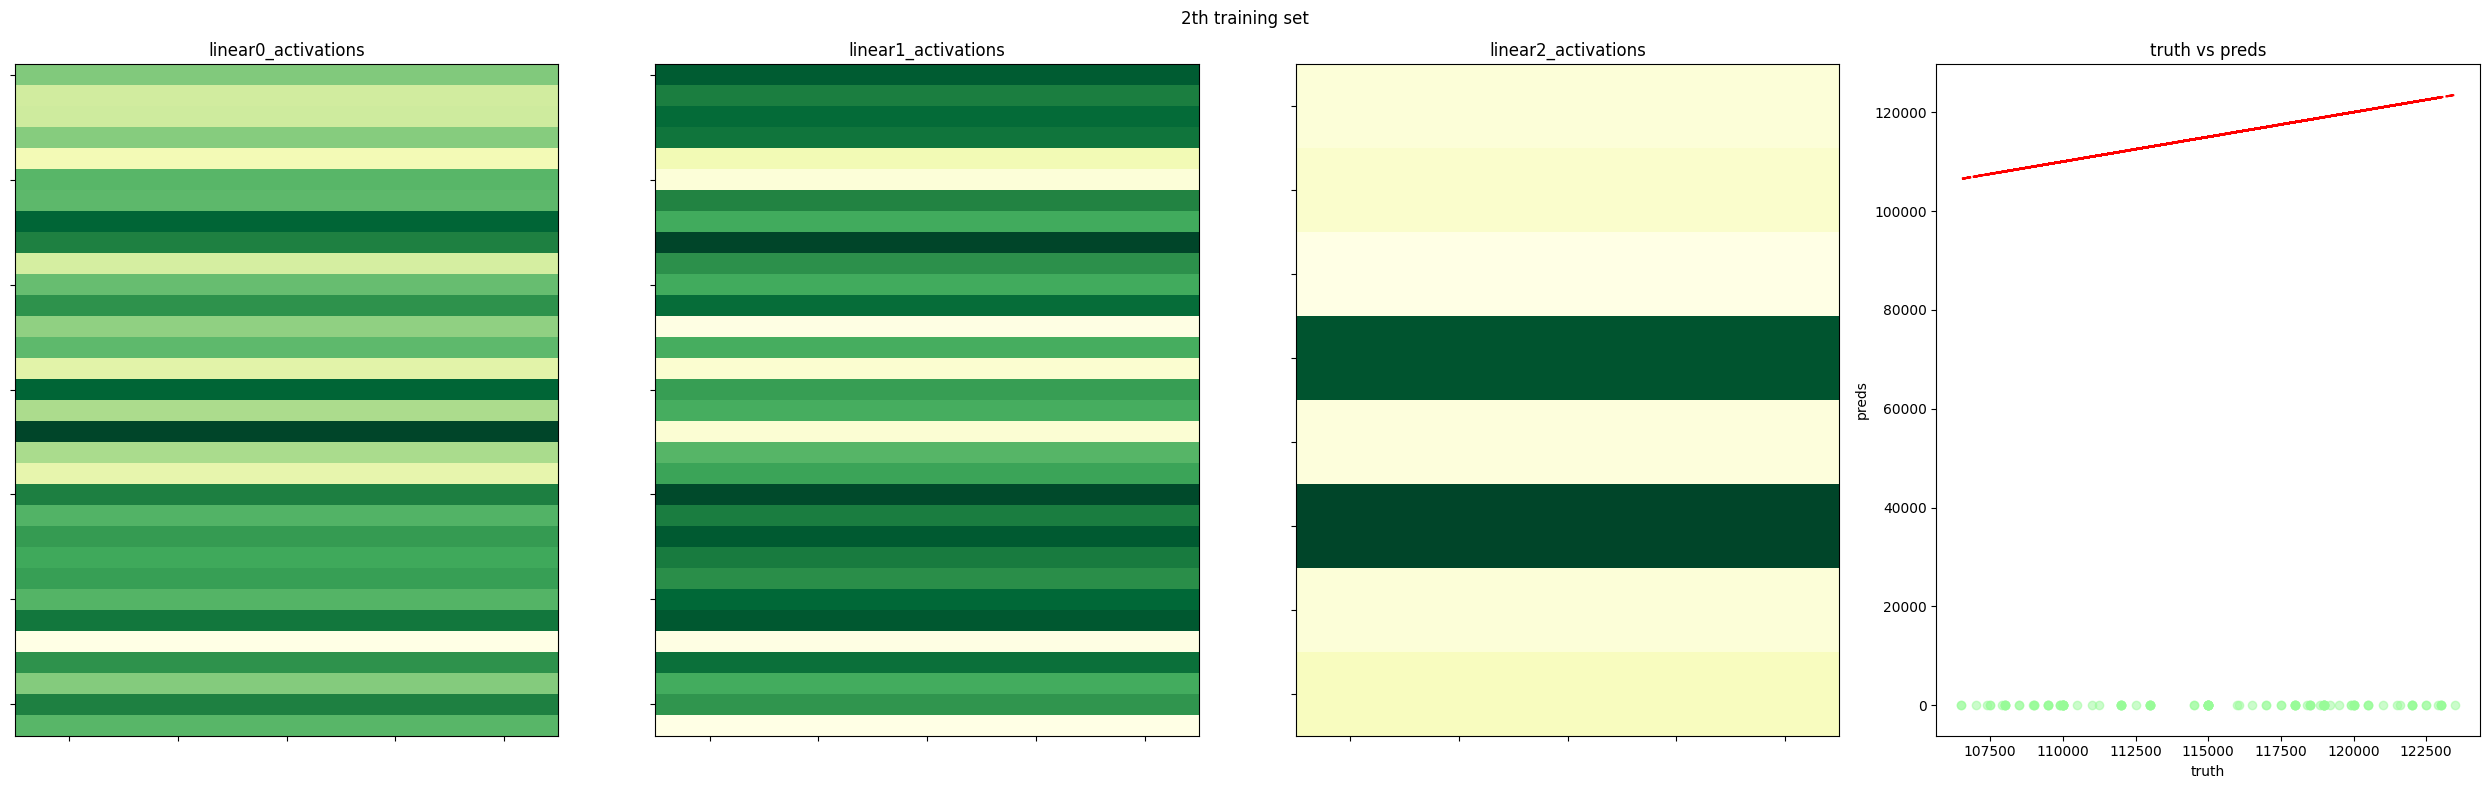

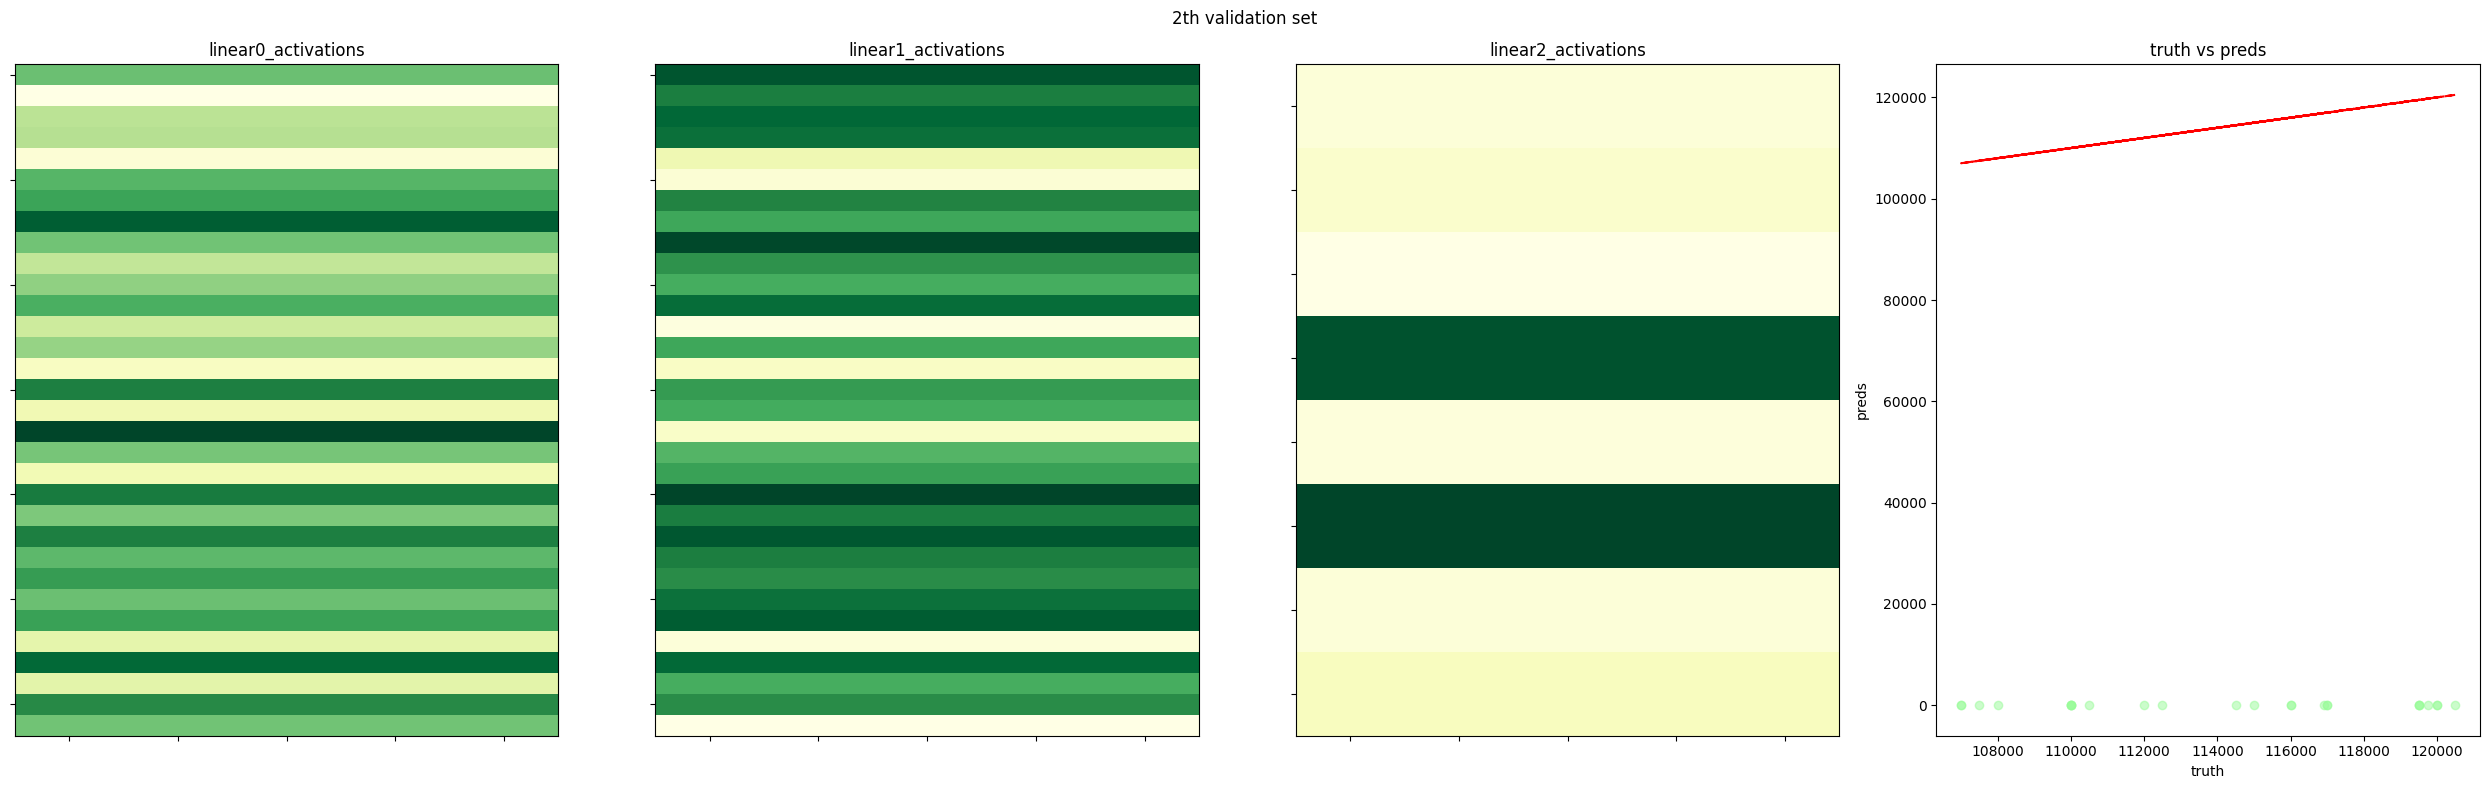

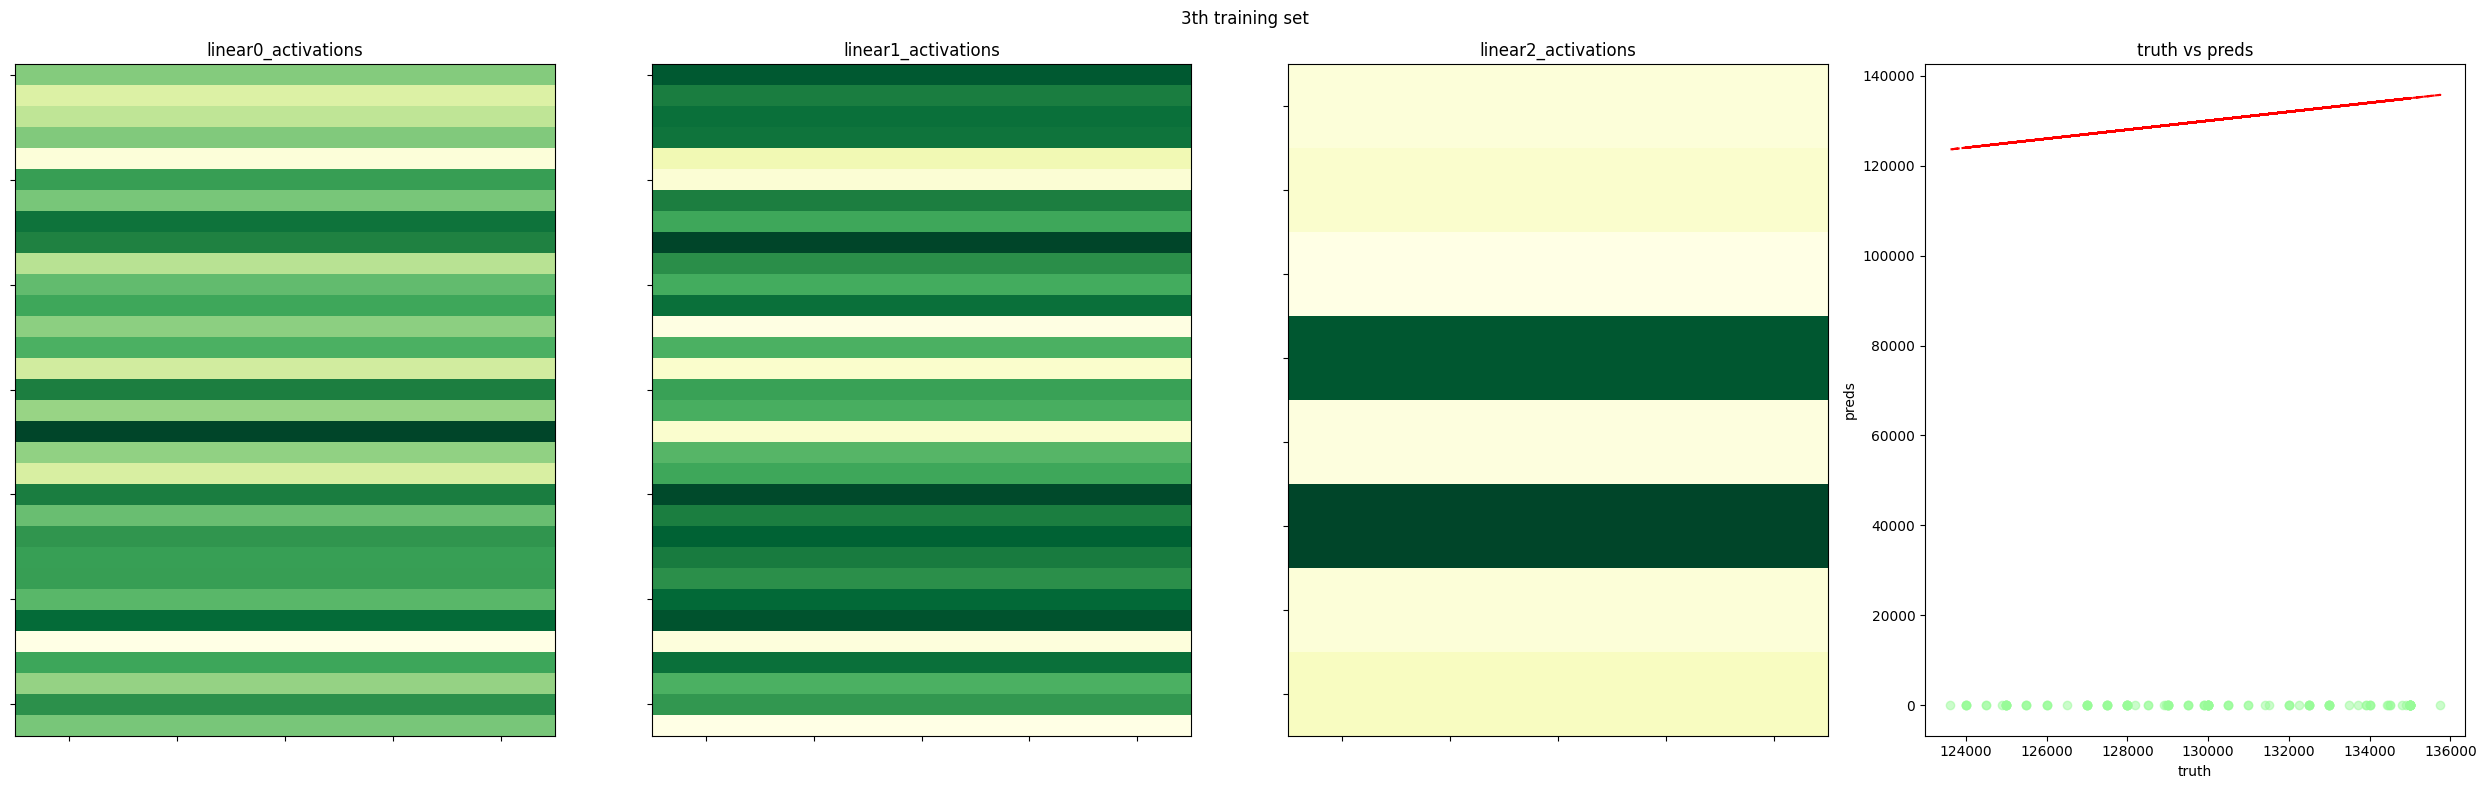

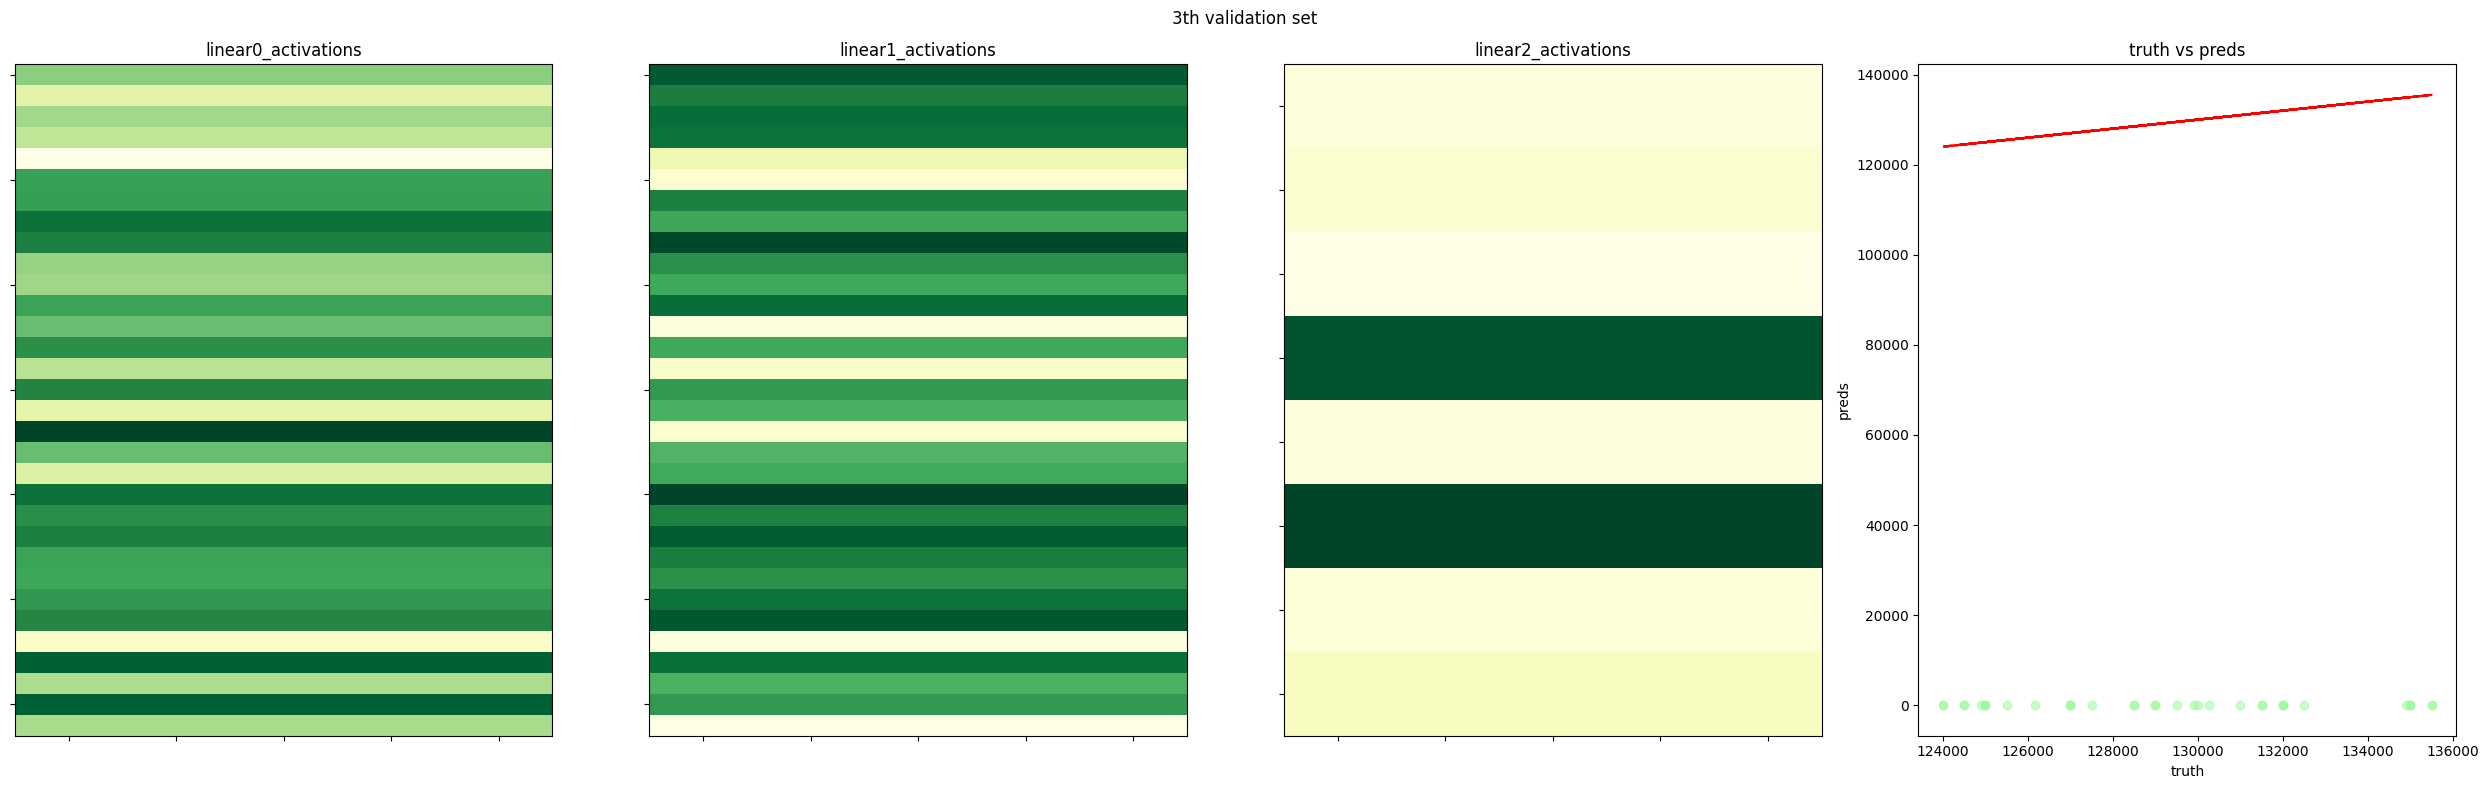

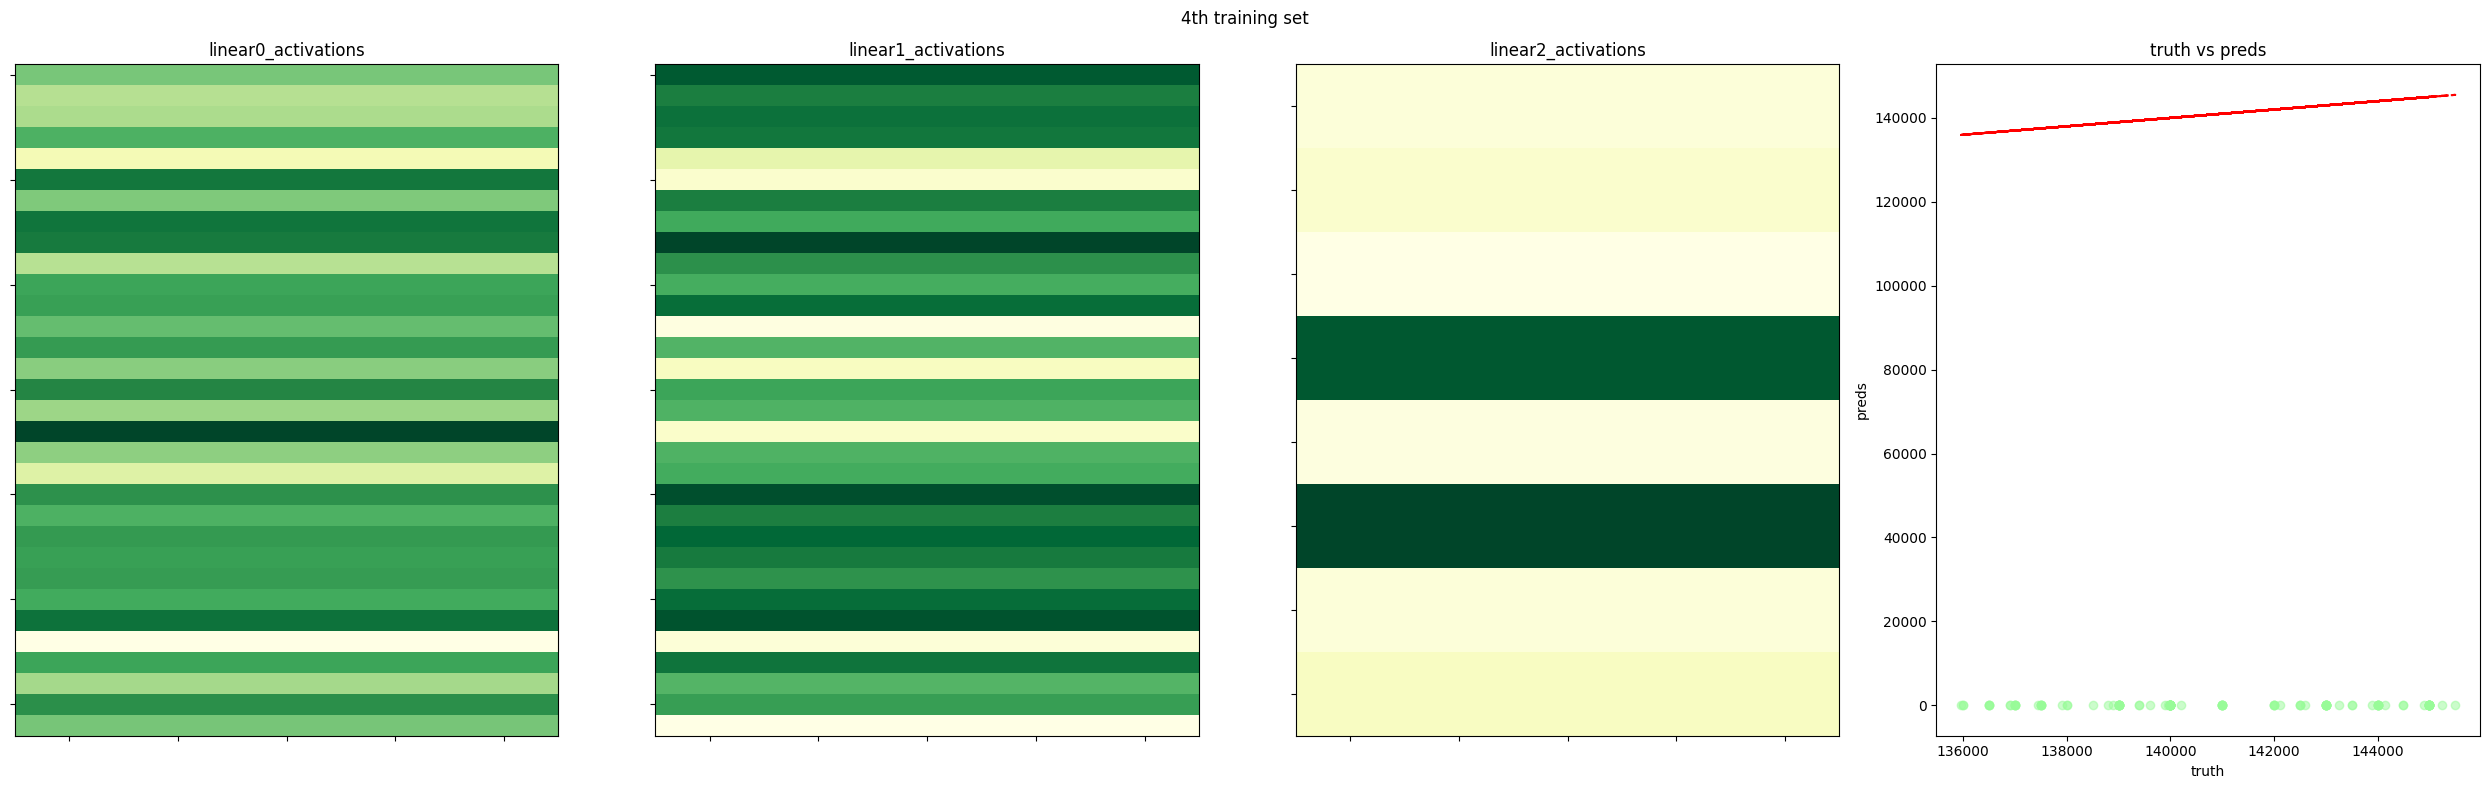

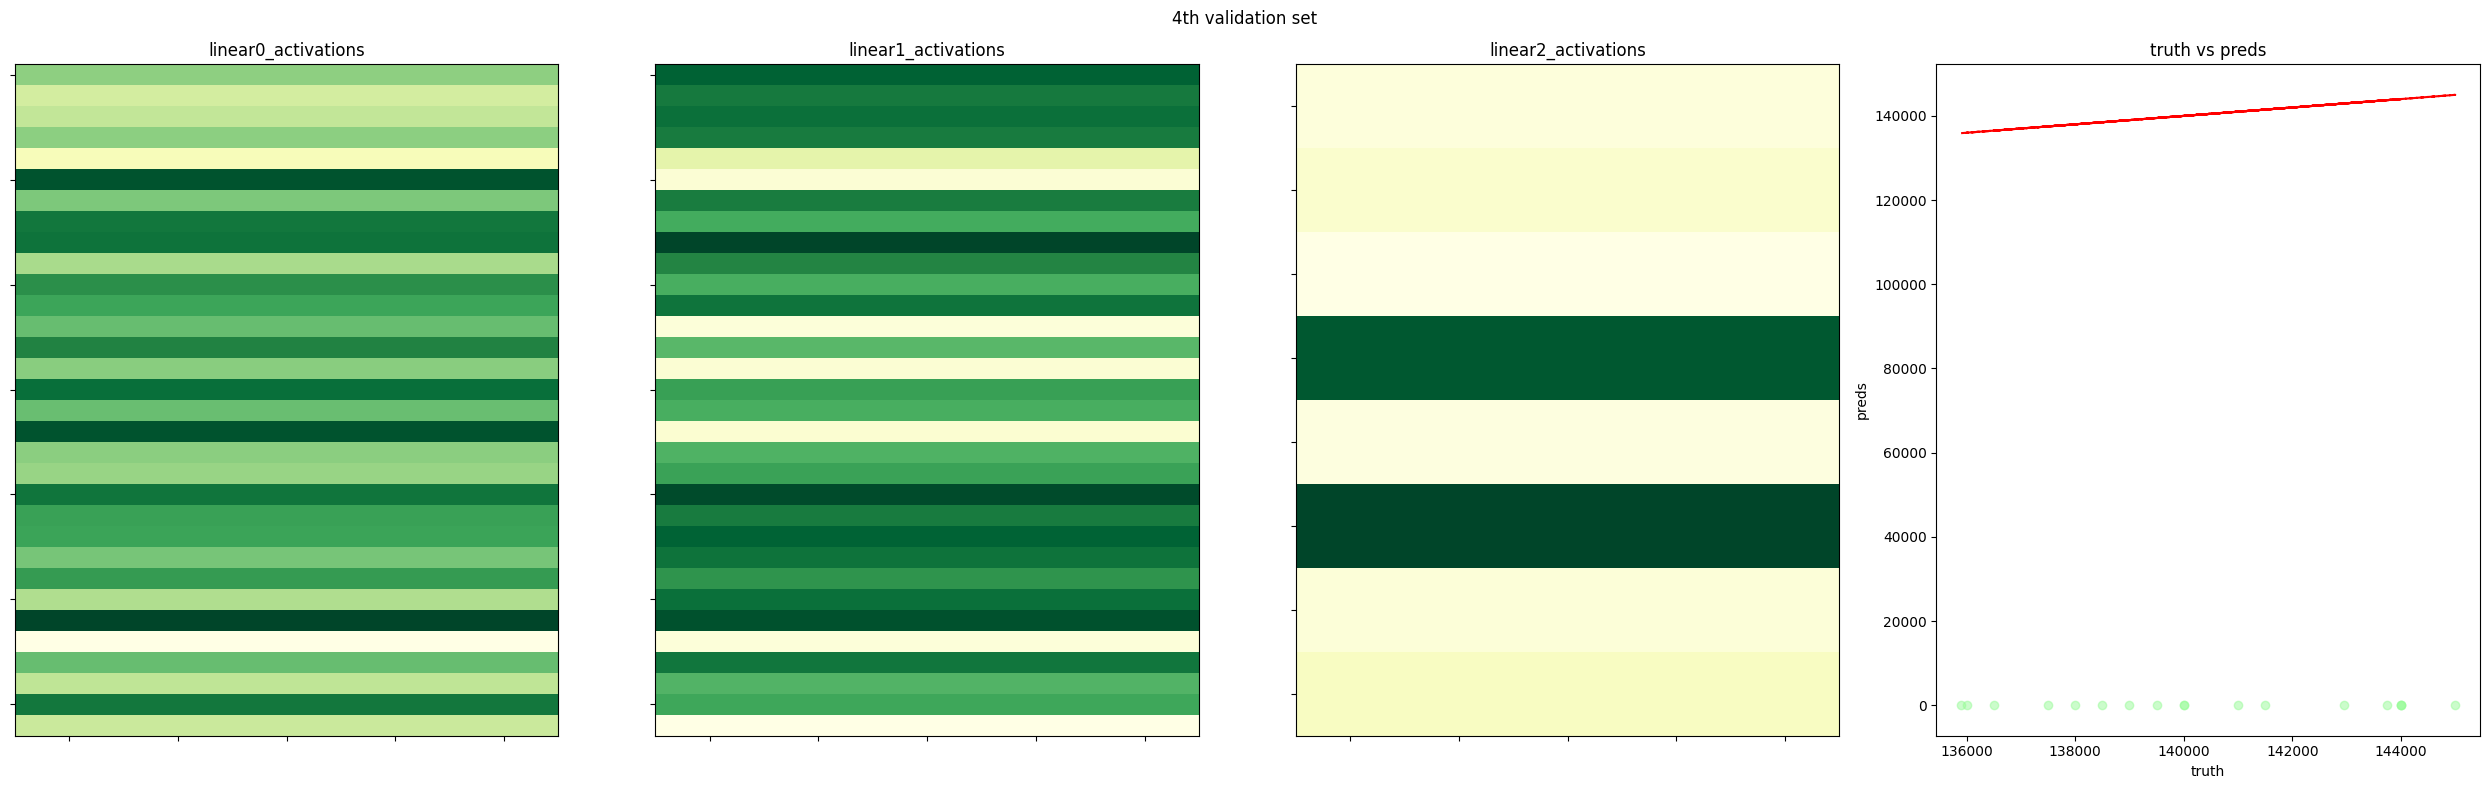

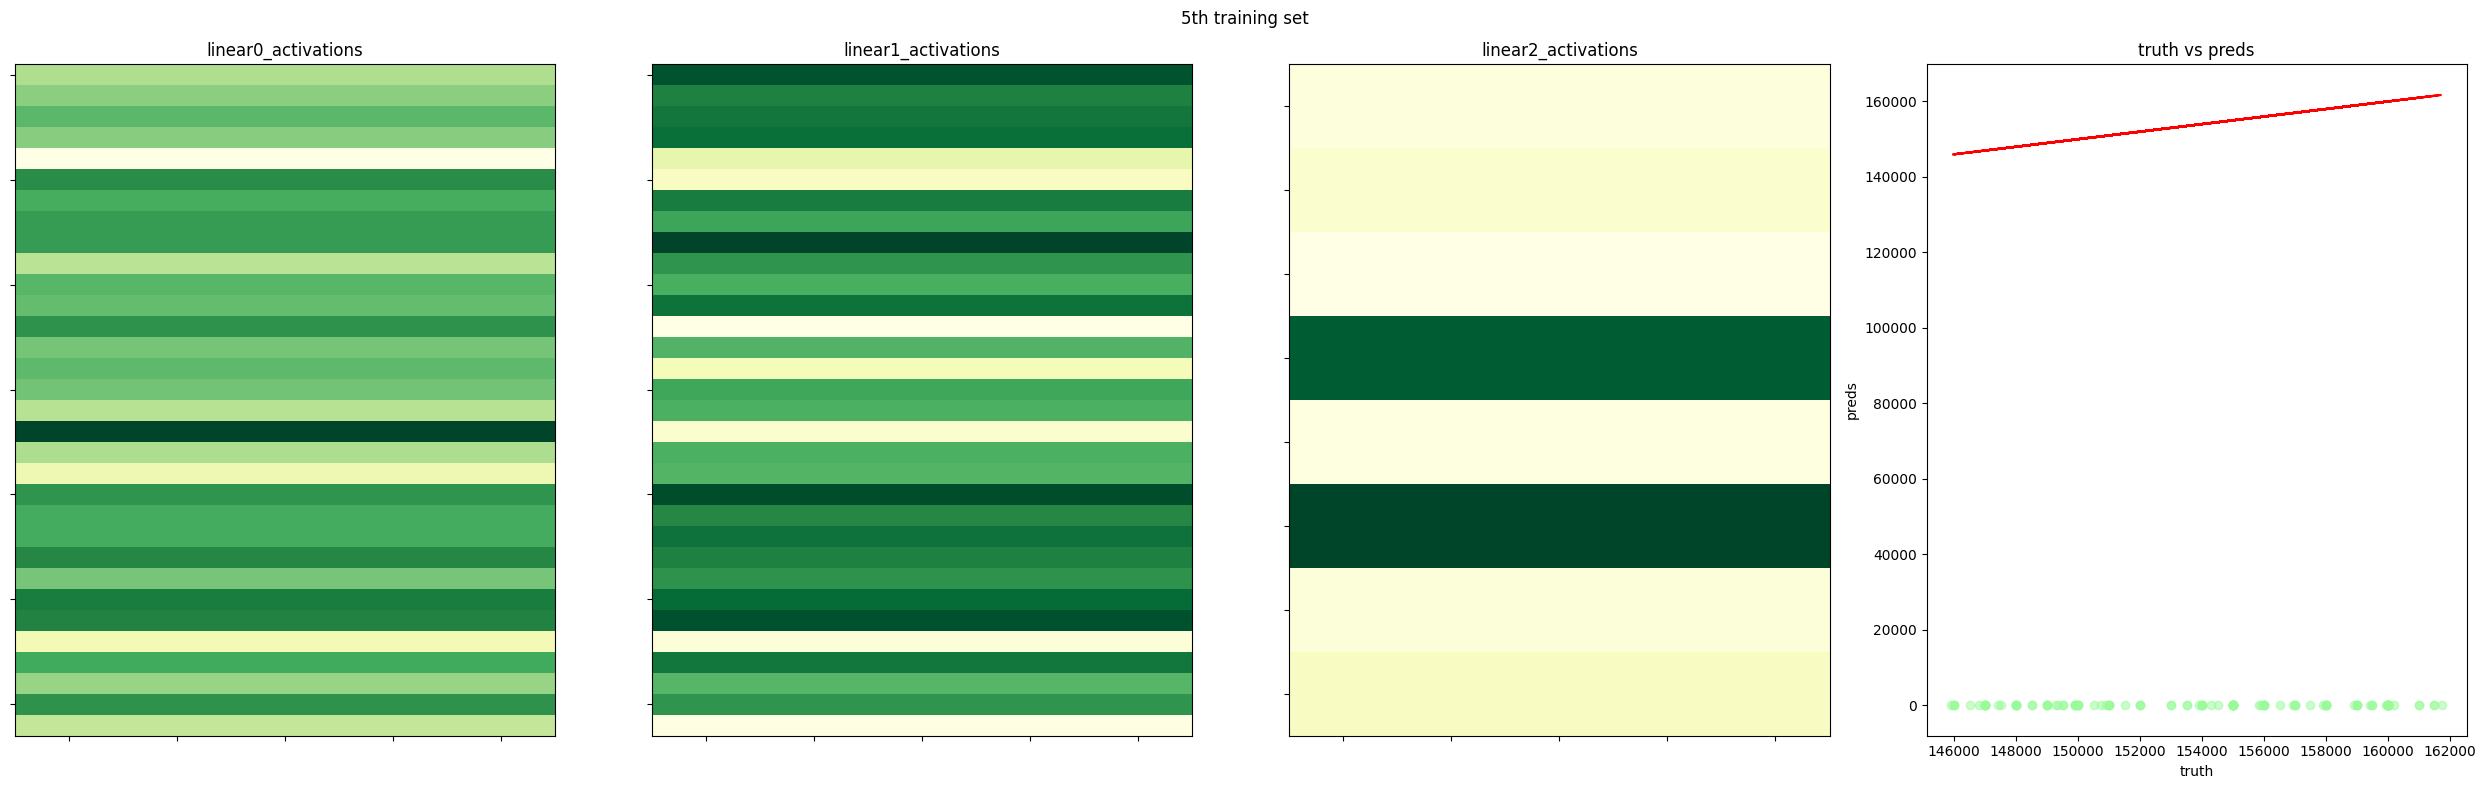

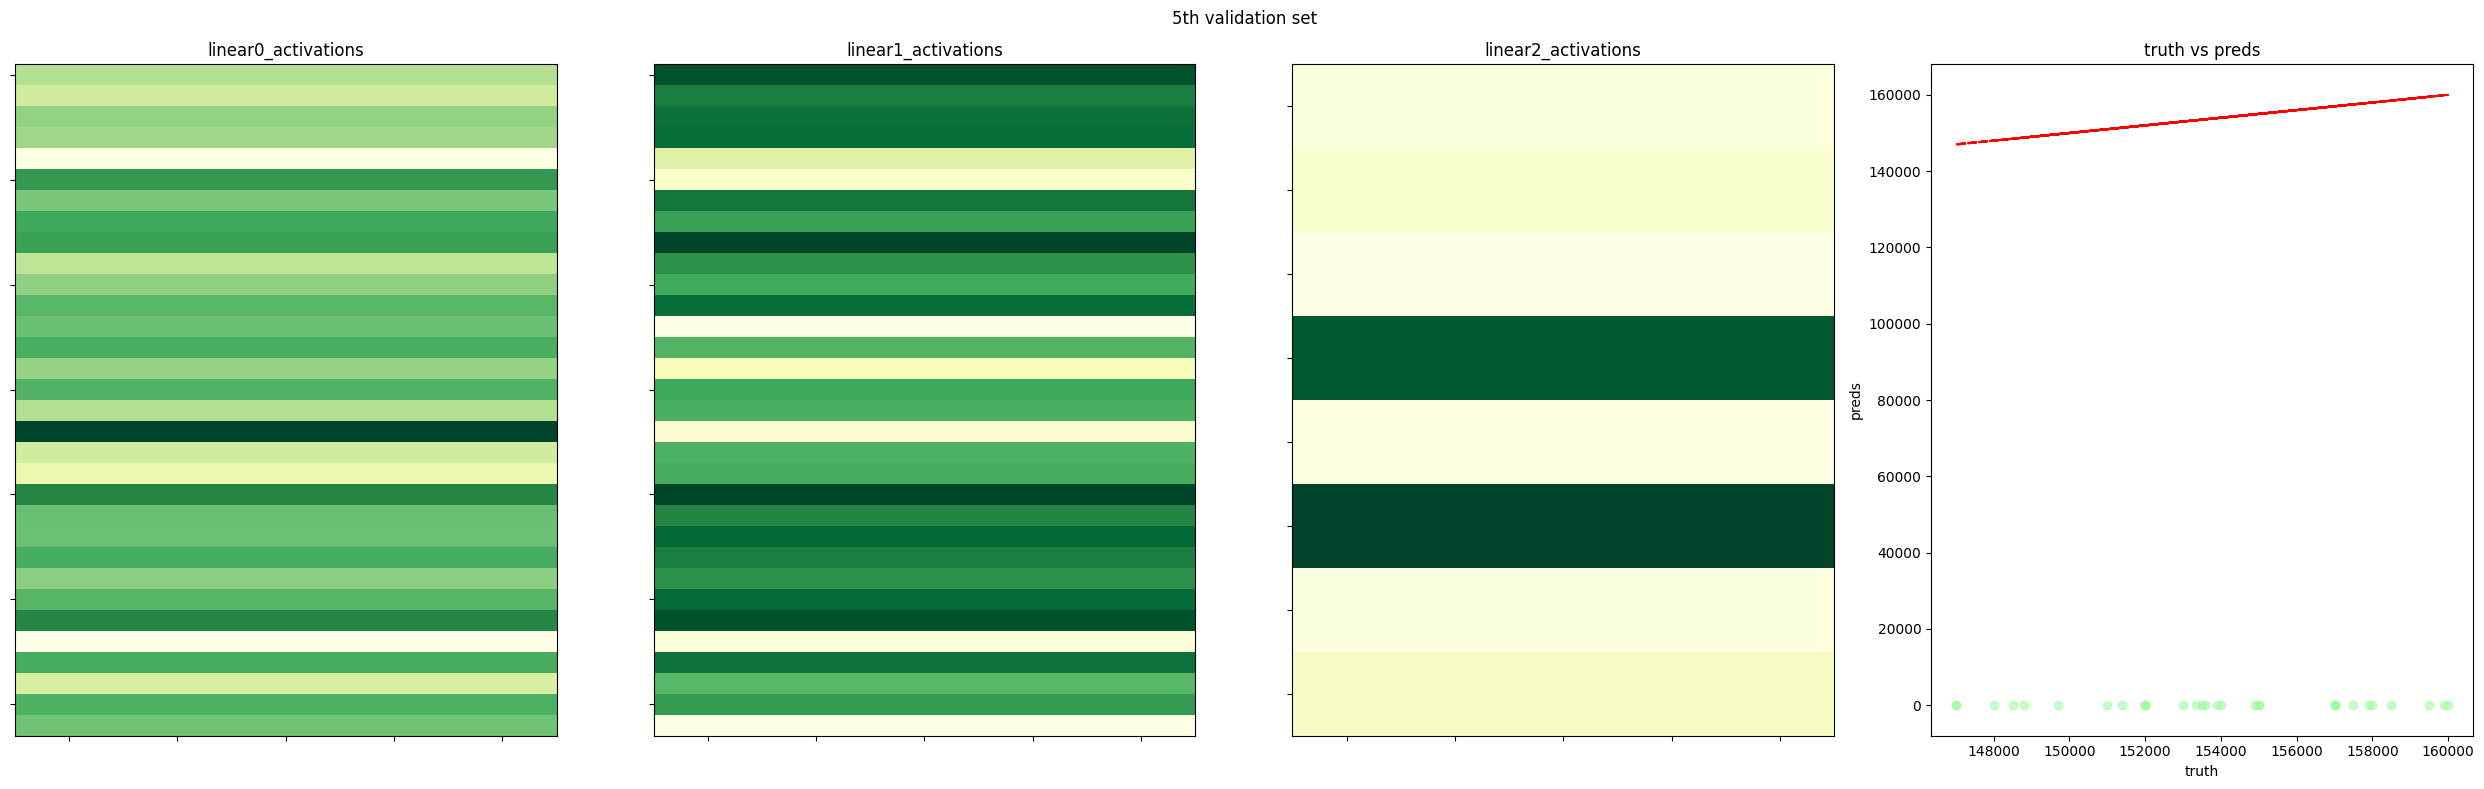

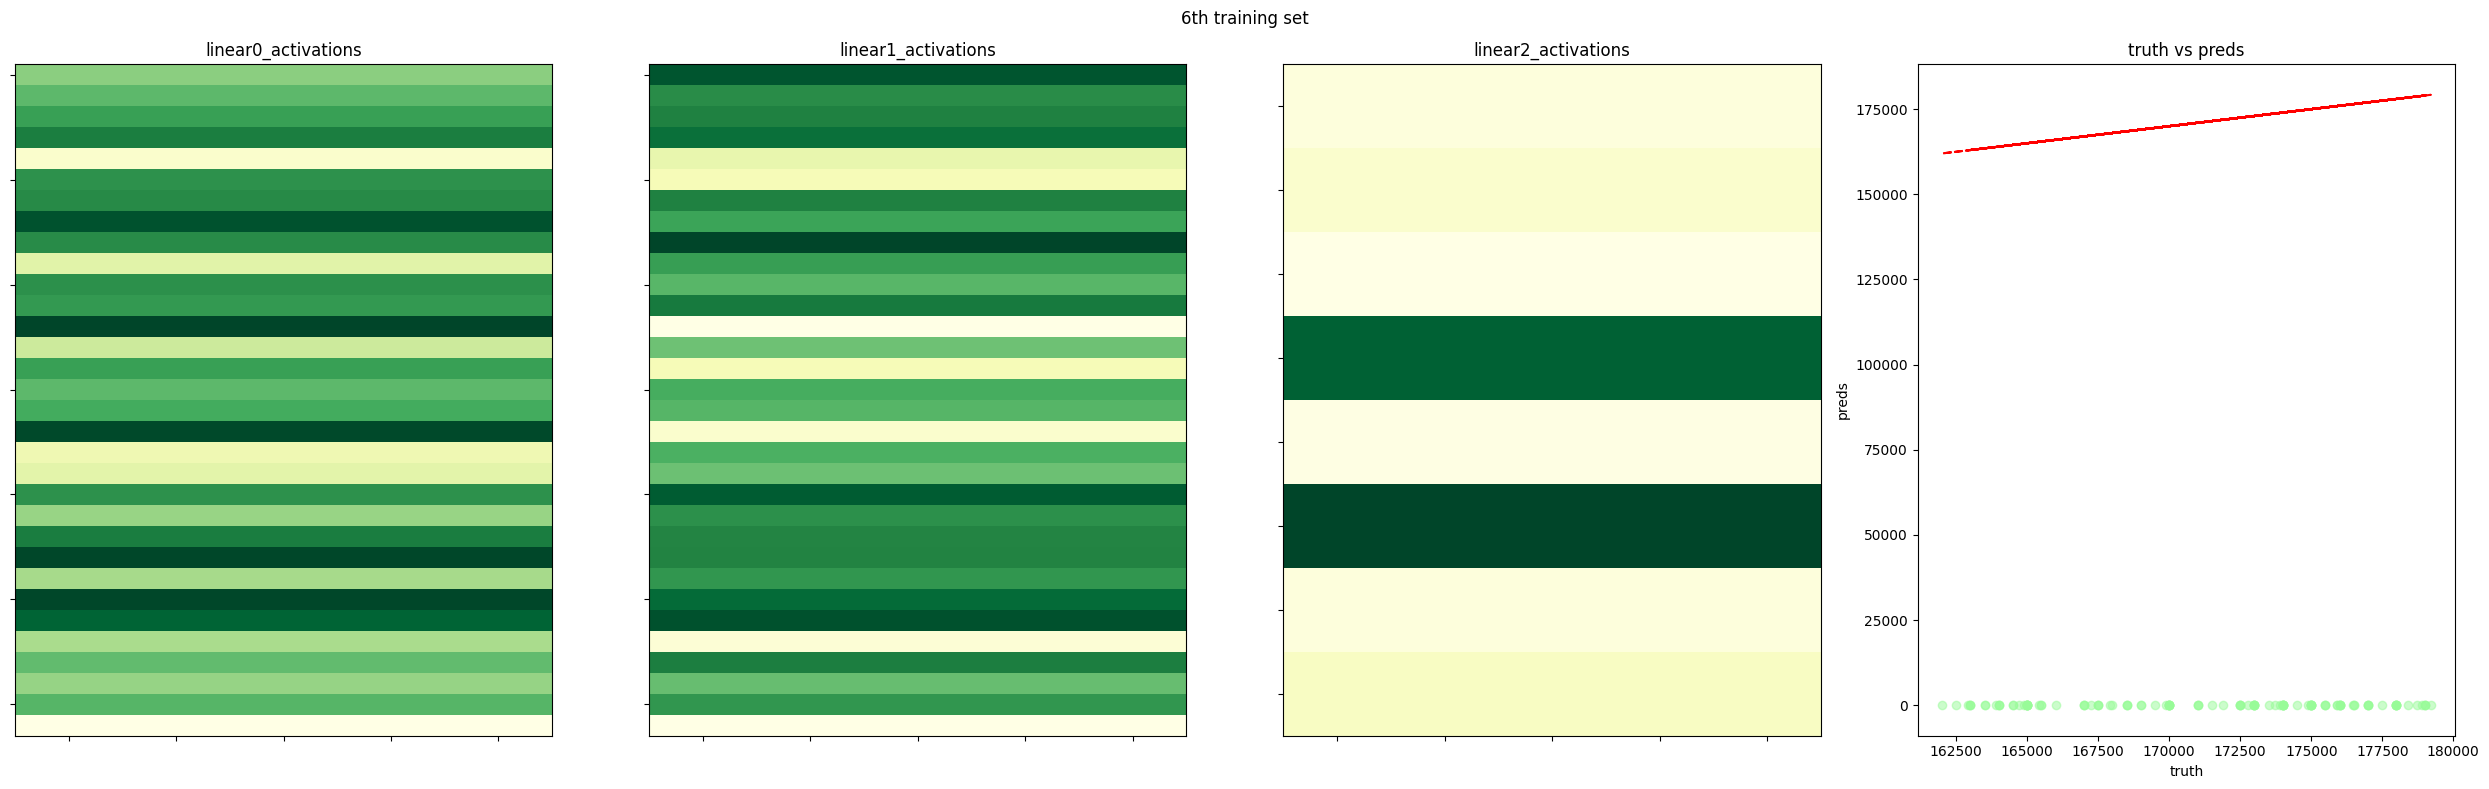

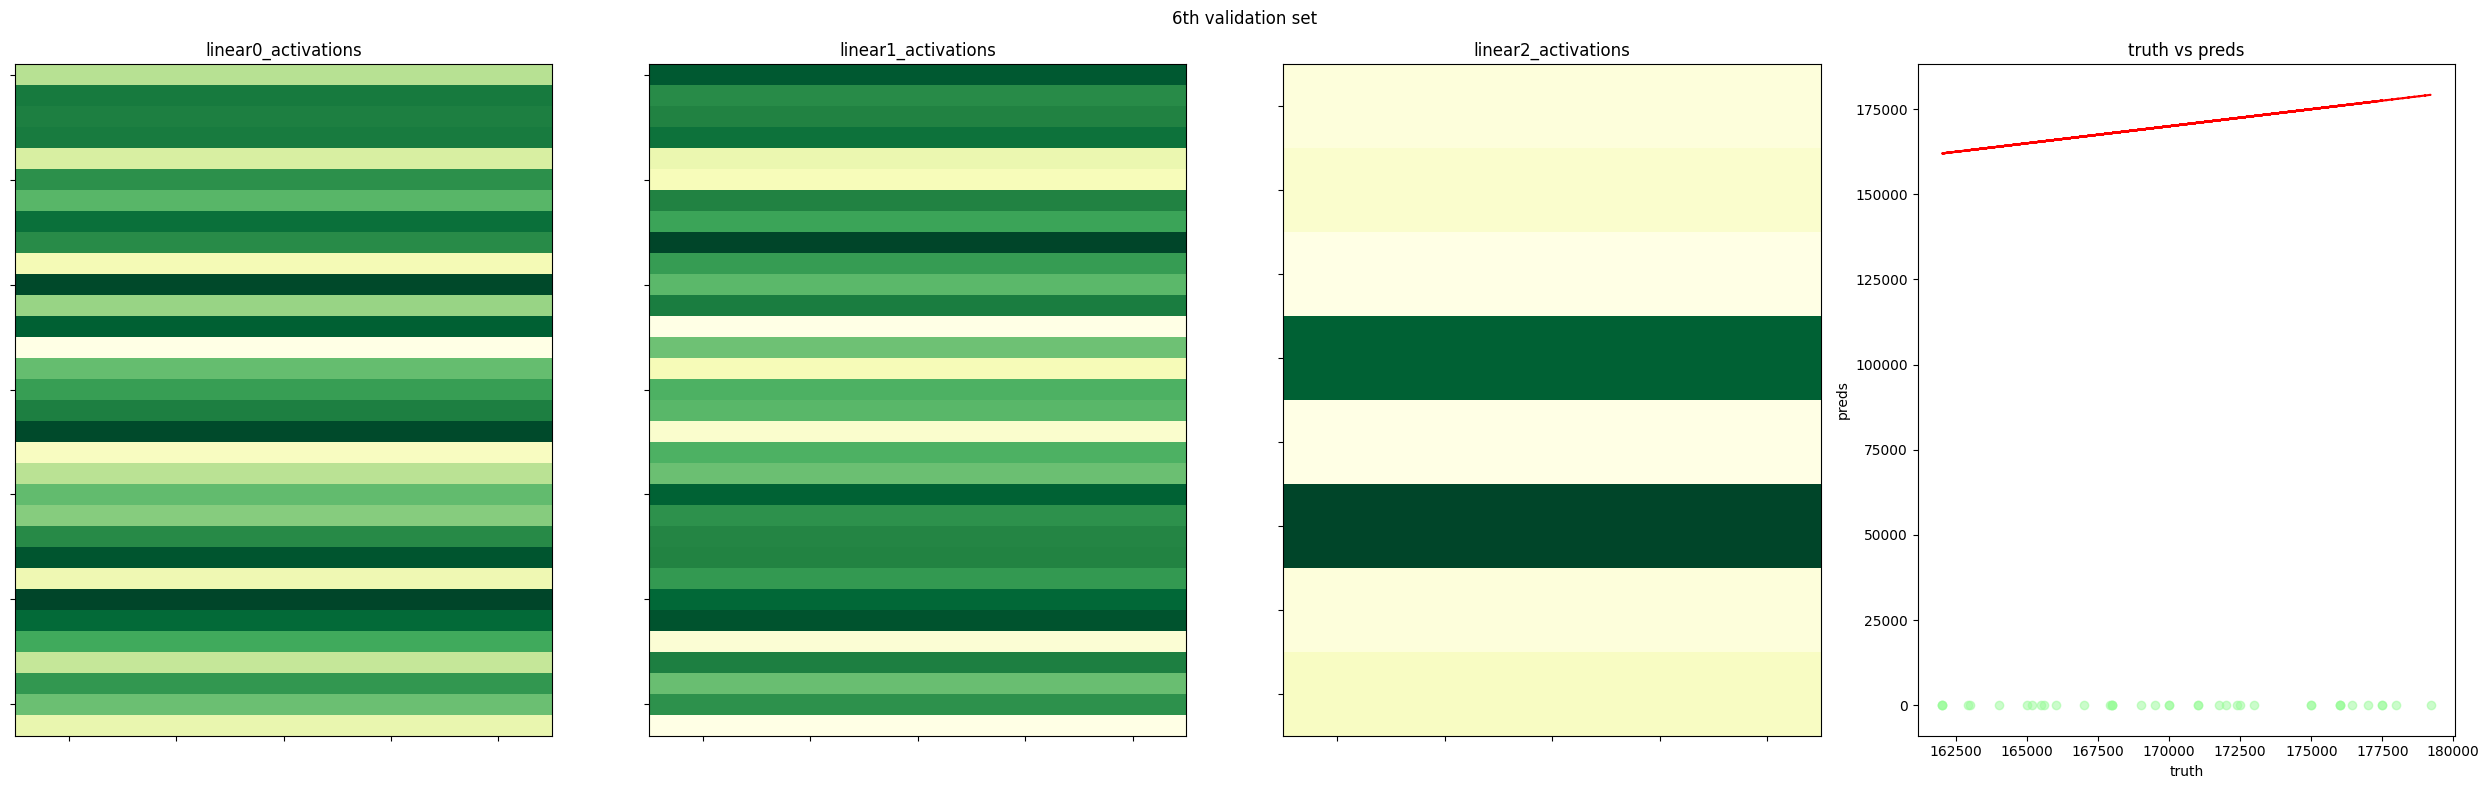

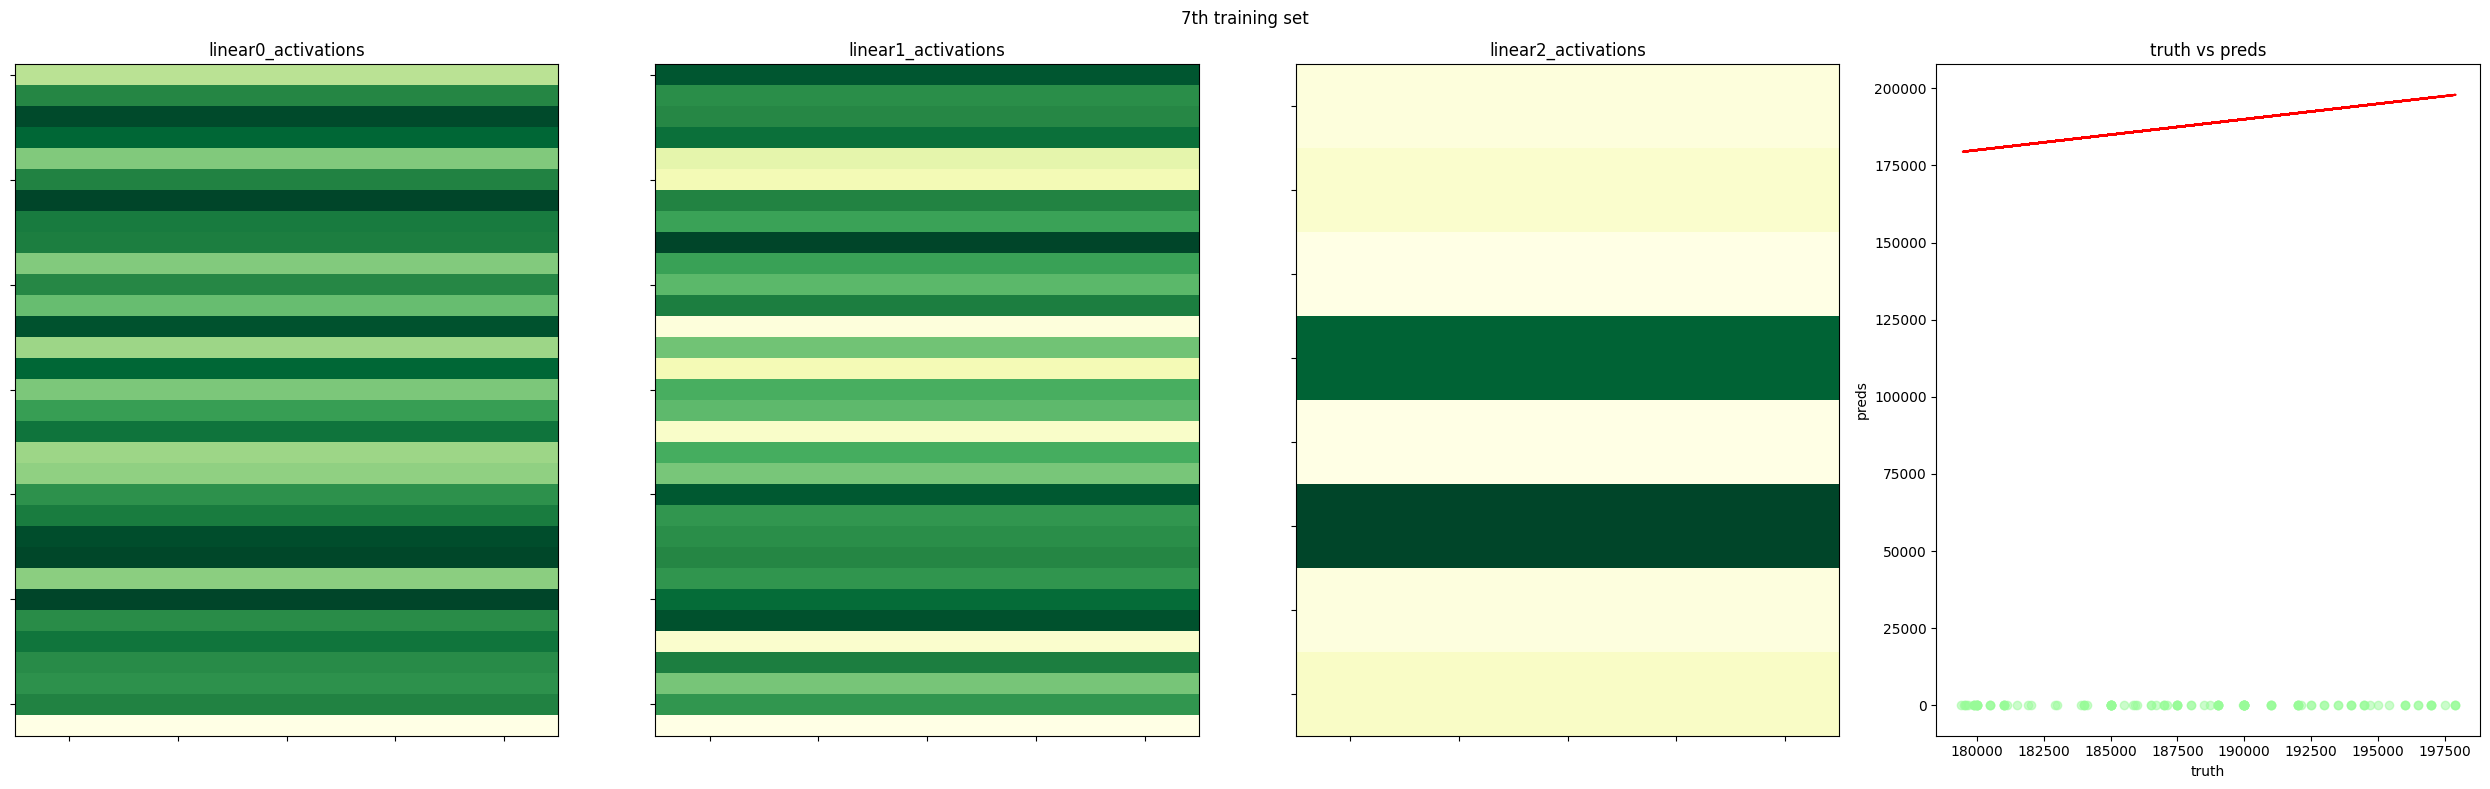

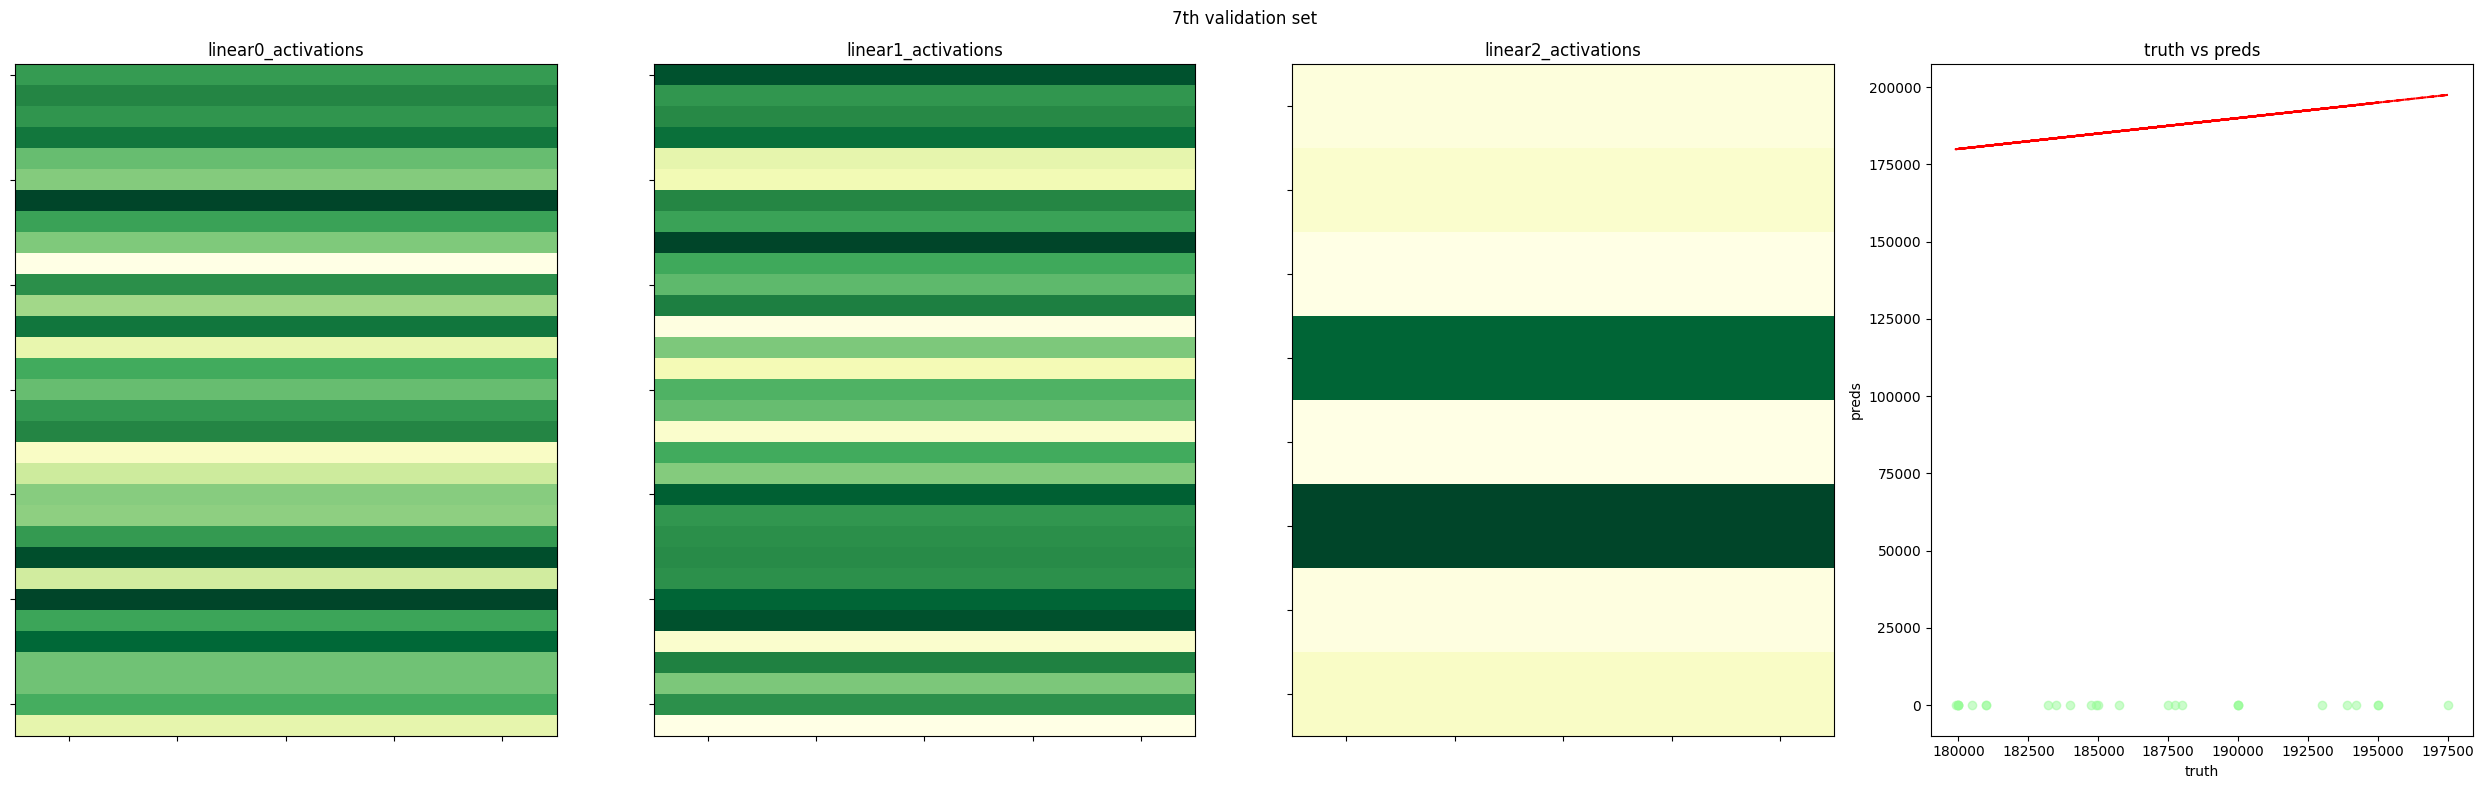

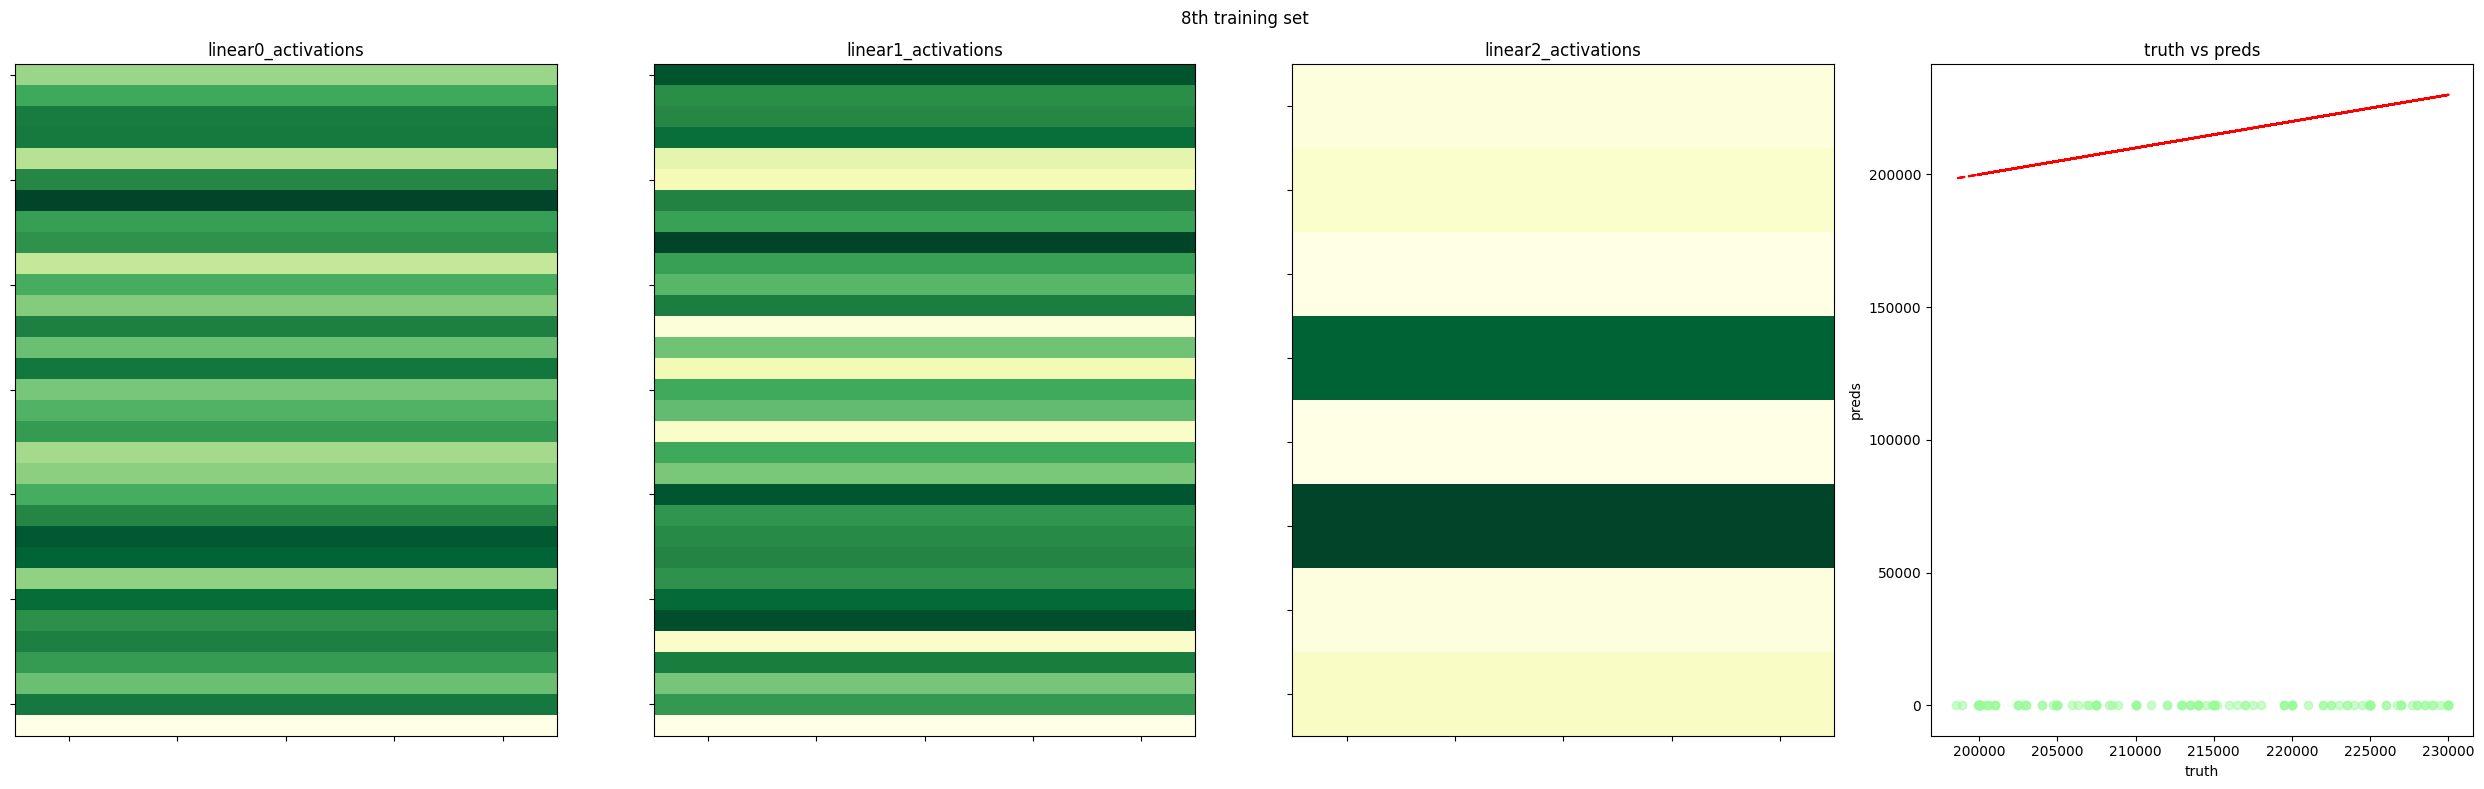

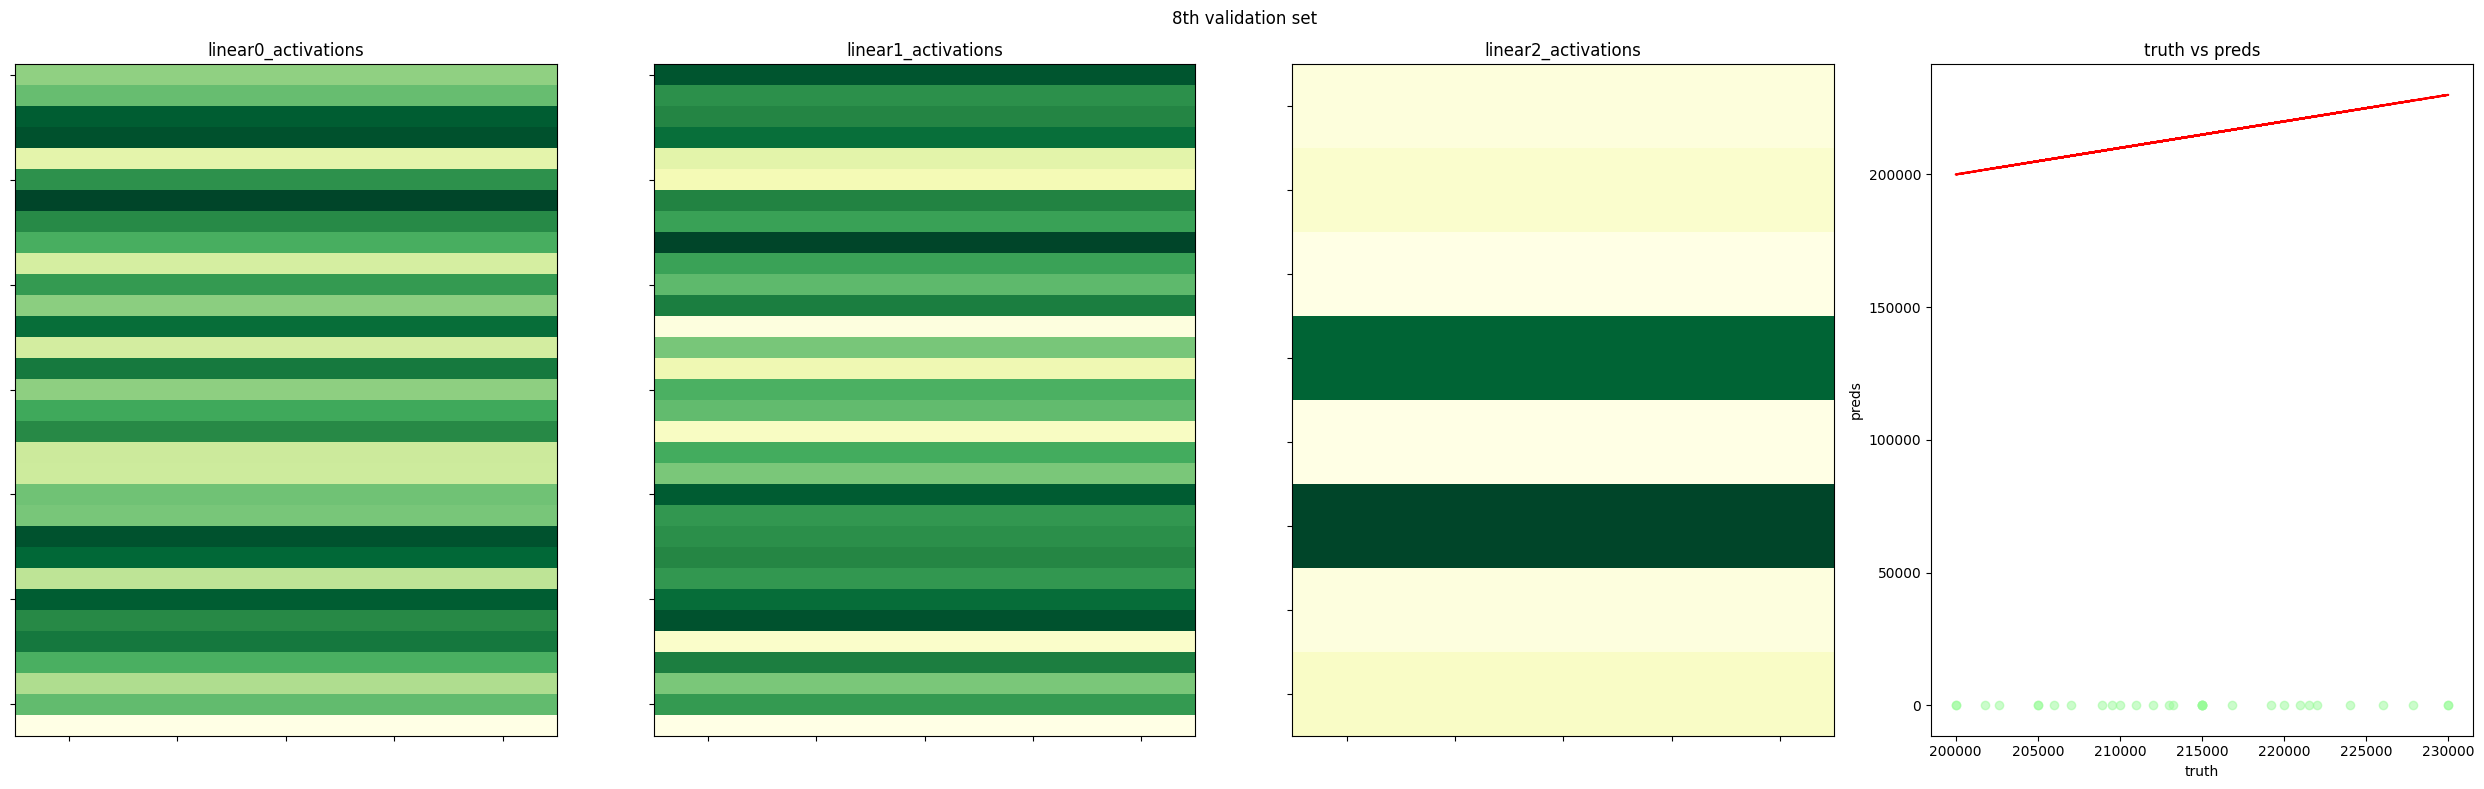

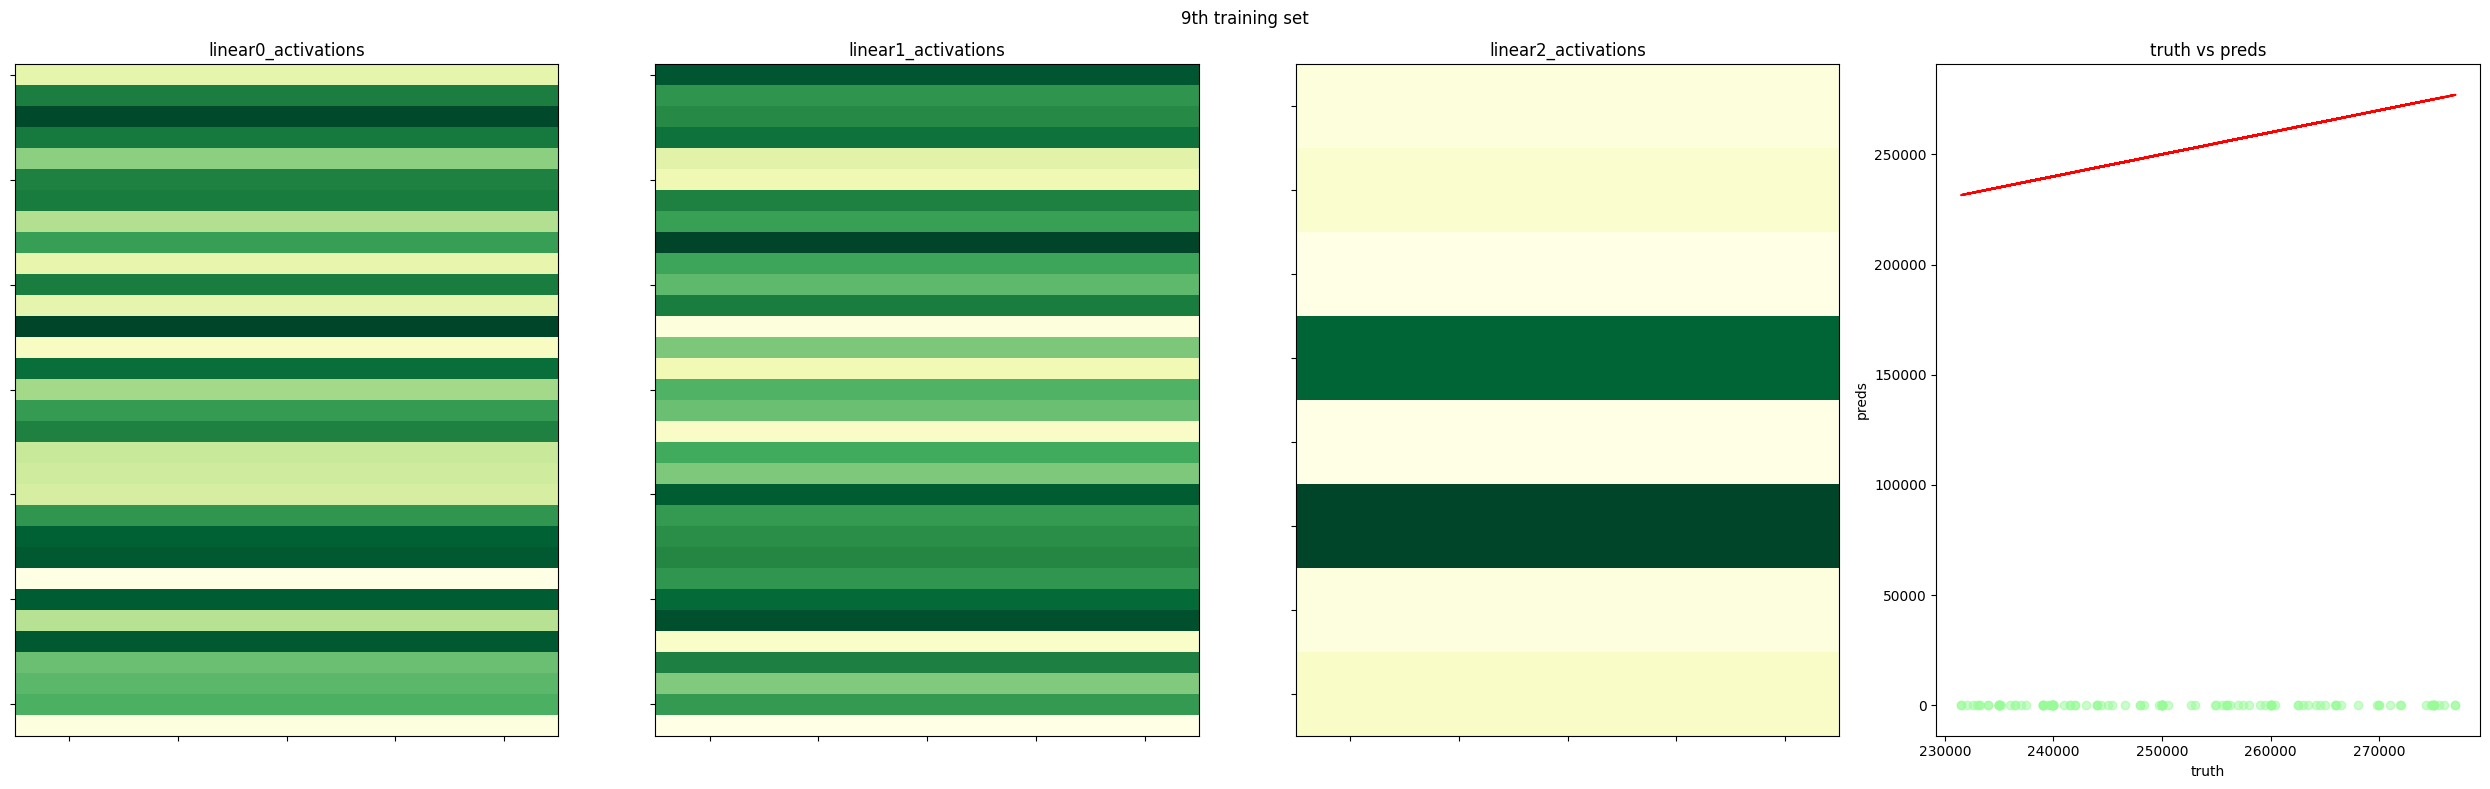

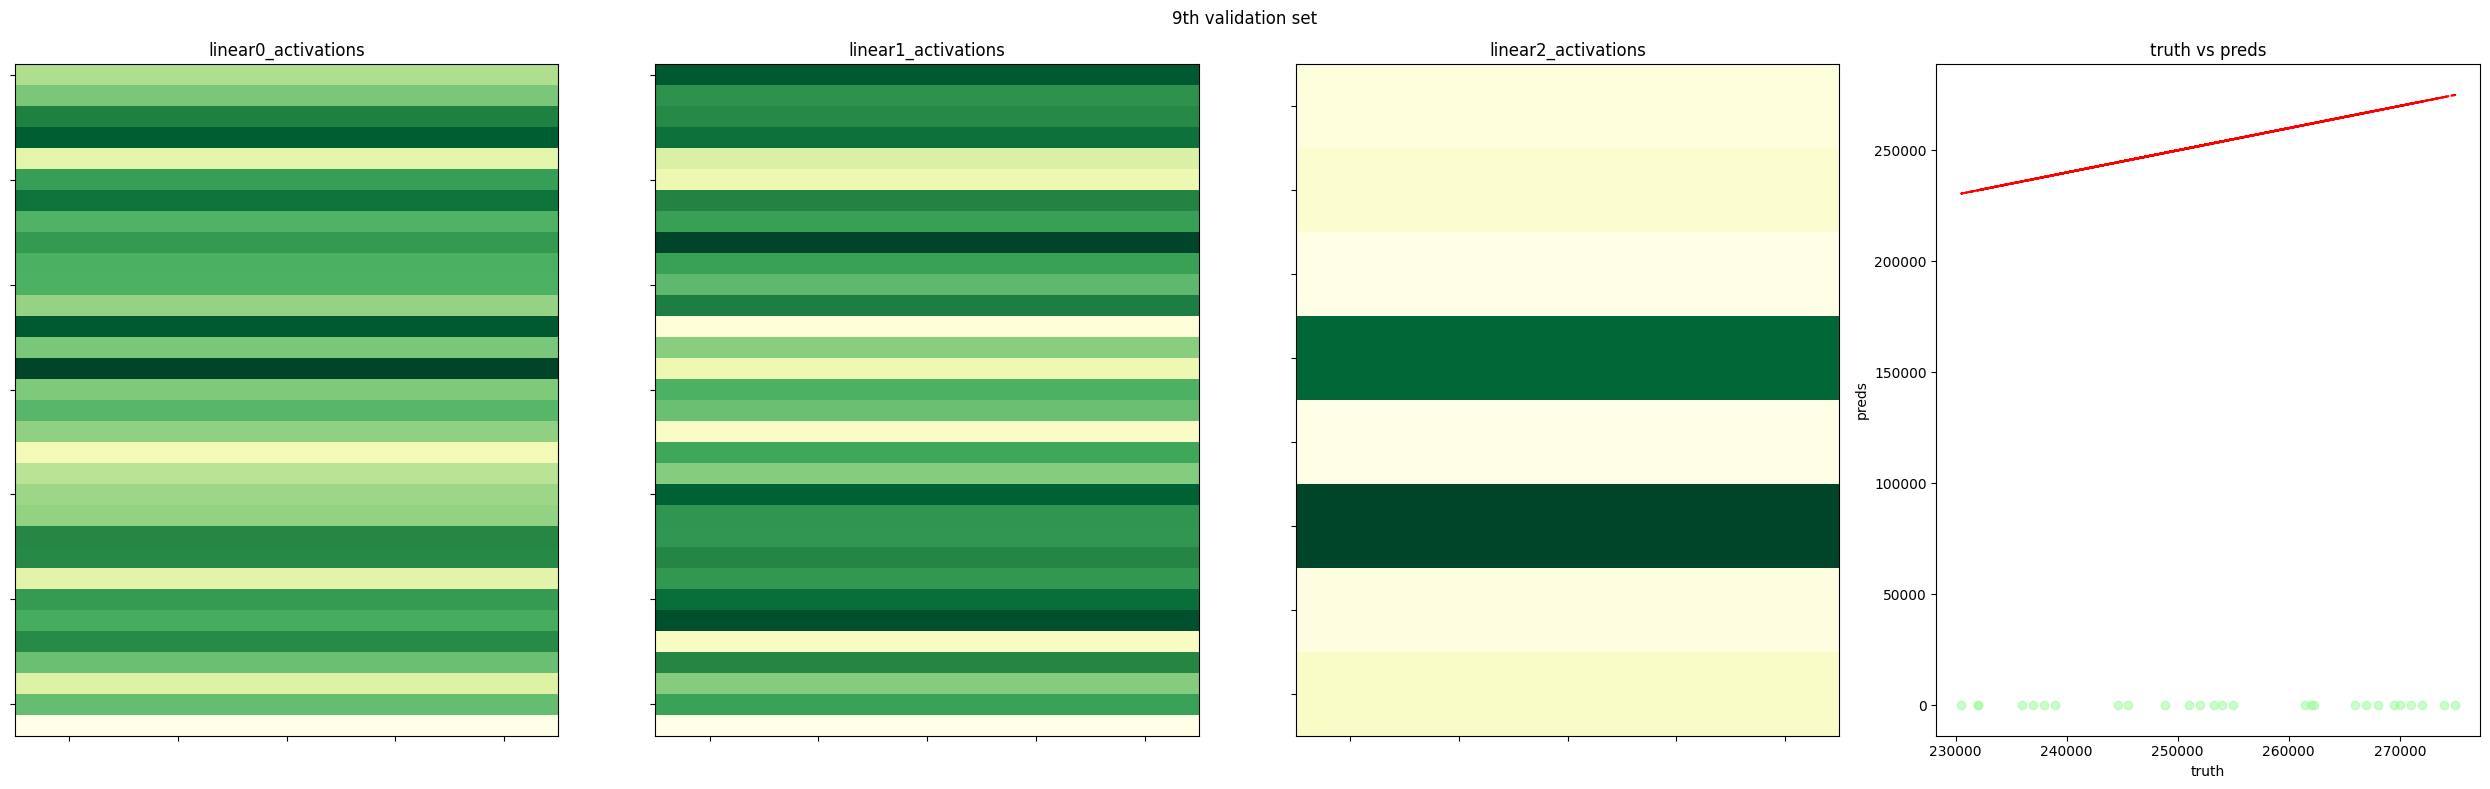

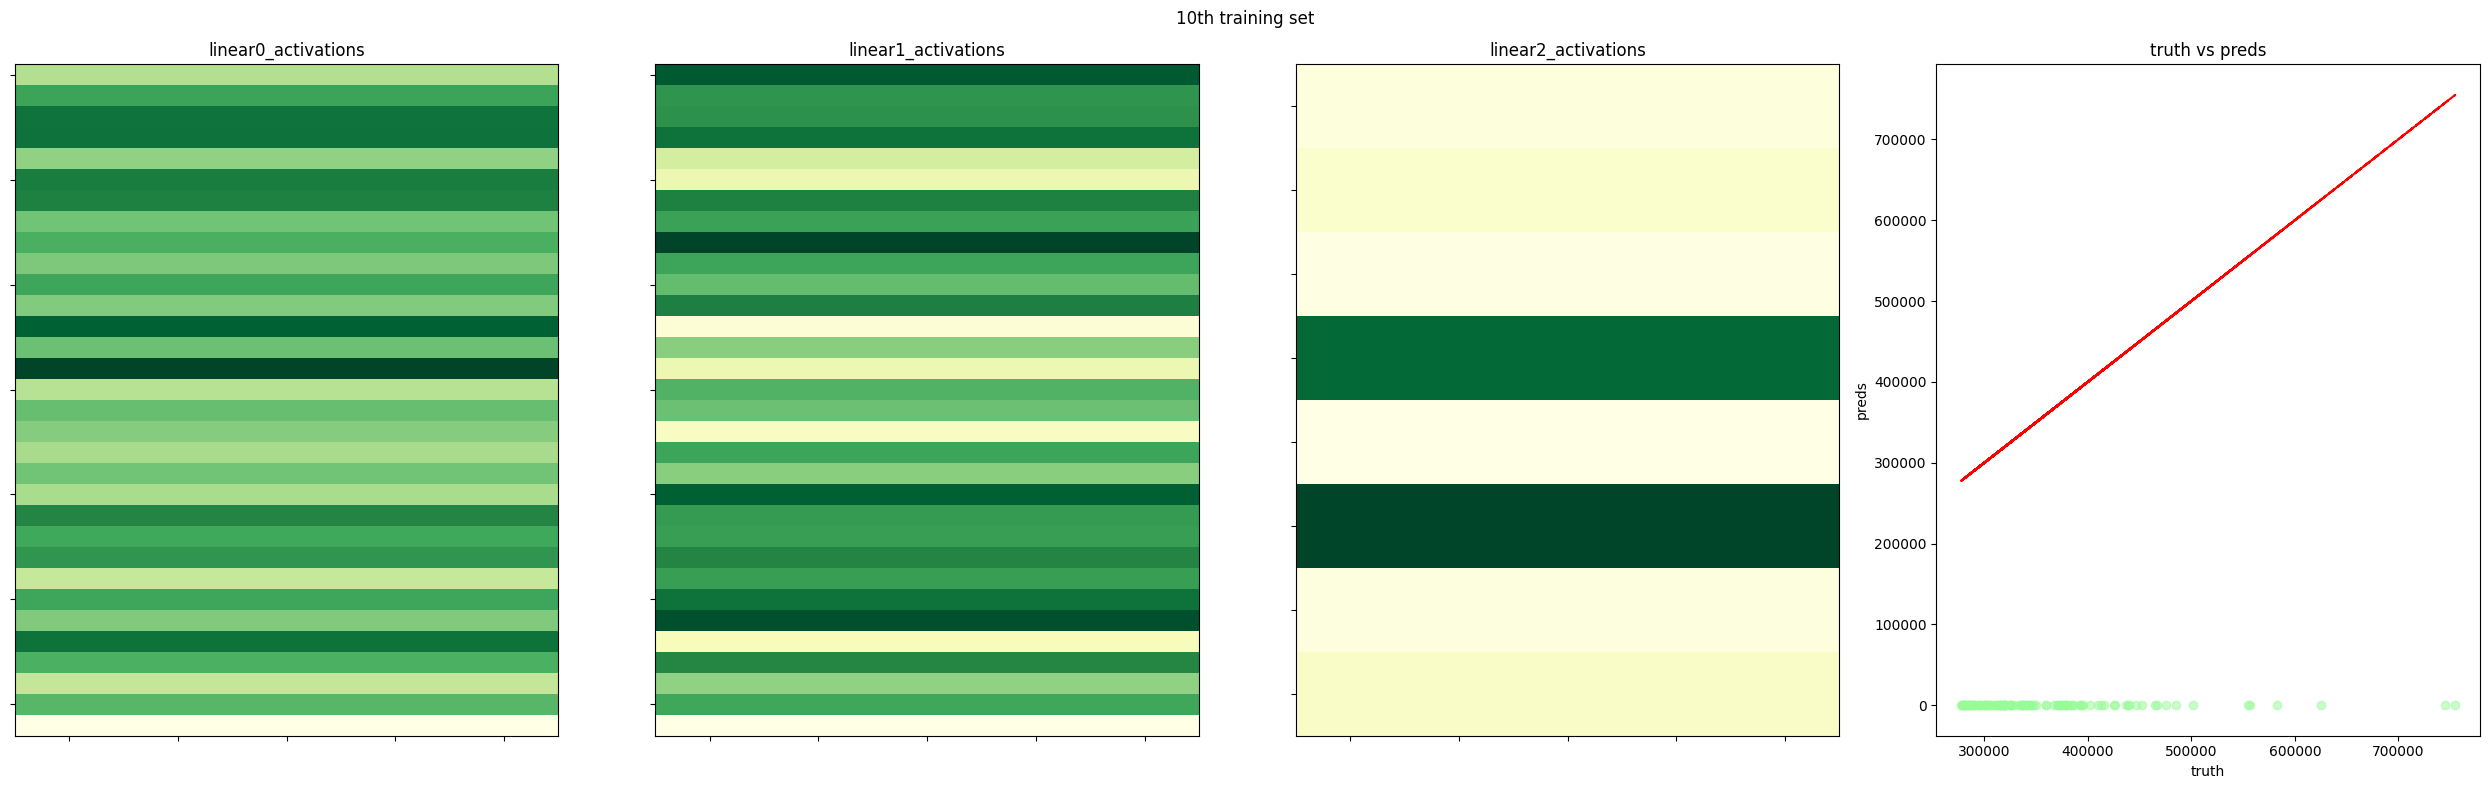

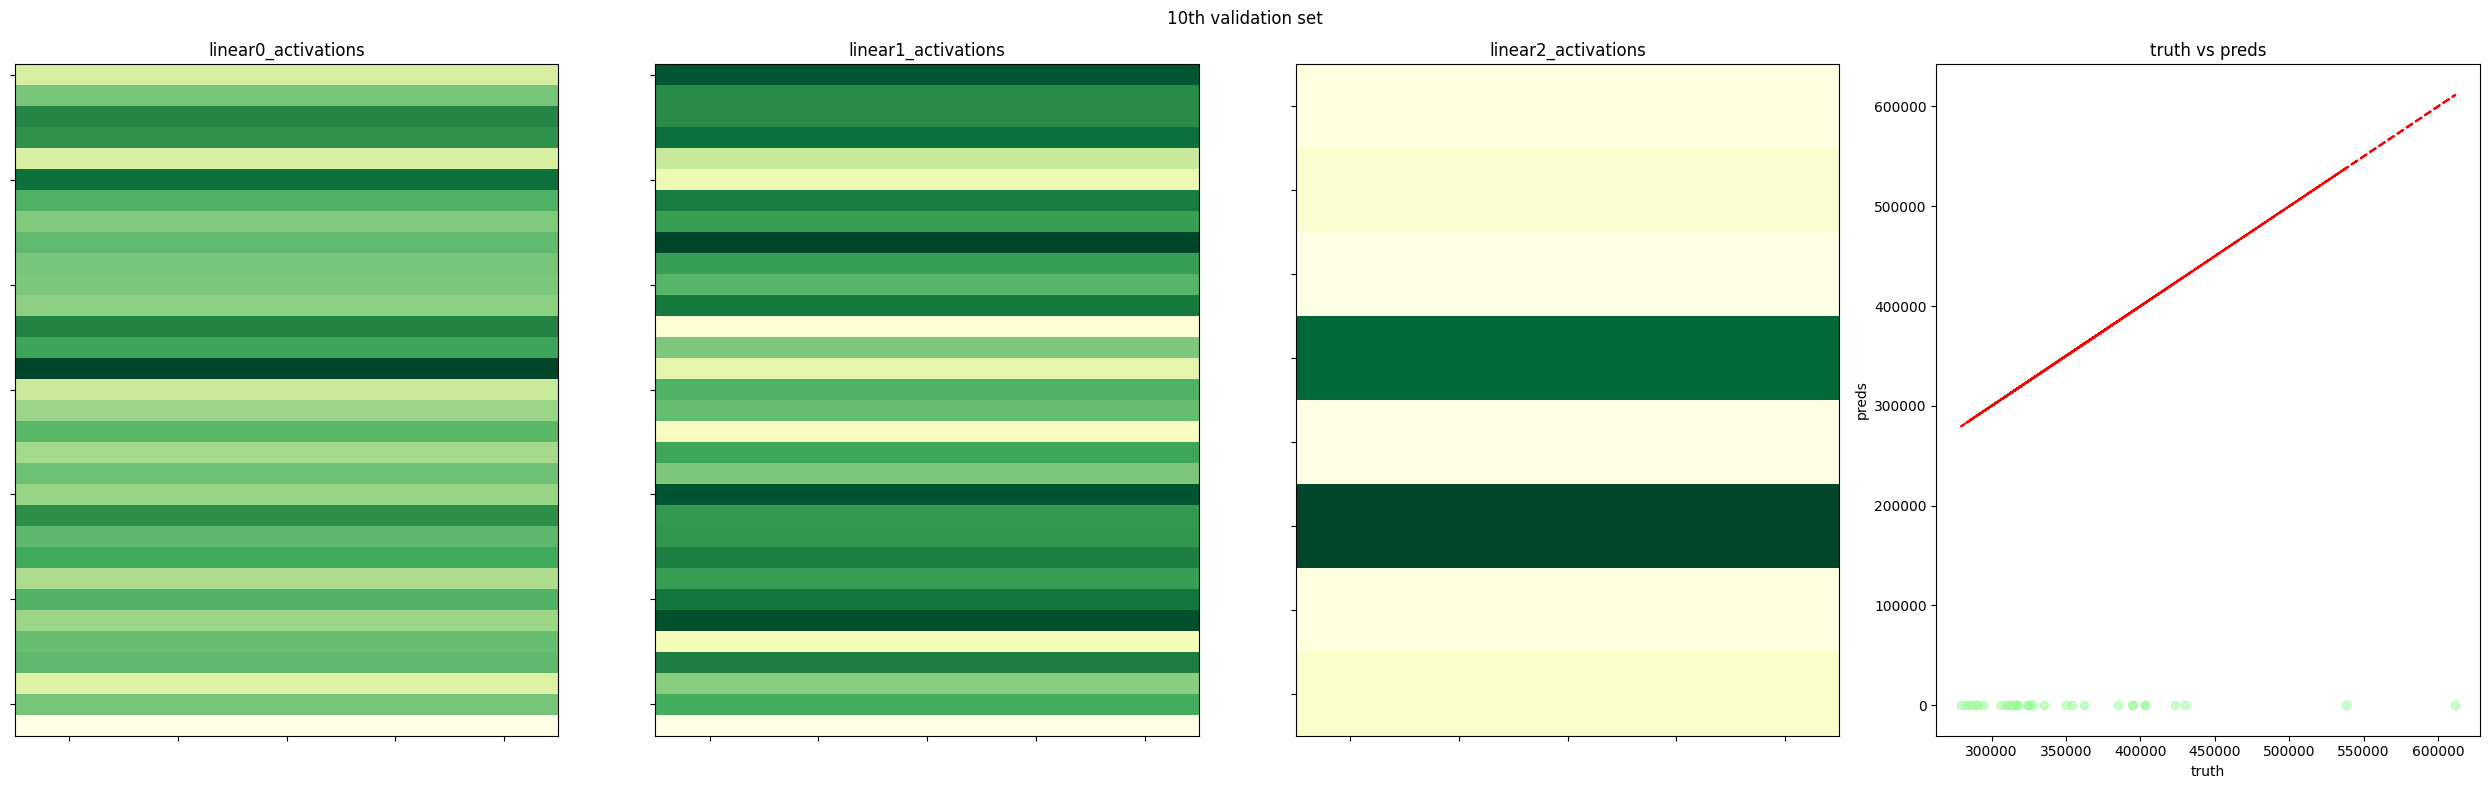

In [271]:
X_train_transformed_tn = torch.tensor(X_train_transformed, dtype=torch.float32)
y_train_tn = torch.tensor(y_train, dtype=torch.float32)
X_val_transformed_tn = torch.tensor(X_val_transformed, dtype=torch.float32)
y_val_tn = torch.tensor(y_val.values, dtype=torch.float32)

model.plot_train_val_activations(
    (X_train_transformed_tn, y_train_tn), 
    (X_val_transformed_tn, y_val_tn),
)

In [187]:
model.activations["linear0_activations"]

torch.Size([292, 32])

In [120]:
train_losses, val_losses, _ = train_loop(
    model=BaseNNet(
        input_size=X_train_transformed.shape[1],
        layers=[32, 8]
    ),
    train_set=(X_train_transformed, y_train.values),
    val_set=(X_val_transformed, y_val.values),
    epochs=1000,
    verbose=False,
)

train_losses2, val_losses2, _ = train_loop(
    model=BaseNNet(
        input_size=X_train_transformed.shape[1],
        layers=[32, 8]
    ),
    train_set=(X_train_transformed, y_train.values),
    val_set=(X_val_transformed, y_val.values),
    epochs=1000,
    verbose=False,
)

train_losses3, val_losses3, _ = train_loop(
    model=BaseNNet(
        input_size=X_train_transformed.shape[1],
        layers=[32, 32, 8]
    ),
    train_set=(X_train_transformed, y_train.values),
    val_set=(X_val_transformed, y_val.values),
    epochs=1000,
    verbose=False,
)

train_losses4, val_losses4, _ = train_loop(
    model=BaseNNet(
        input_size=X_train_transformed.shape[1],
        layers=[32, 64, 64, 8]
    ),
    train_set=(X_train_transformed, y_train.values),
    val_set=(X_val_transformed, y_val.values),
    epochs=1000,
    verbose=False,
)


train_losses5, val_losses5, _ = train_loop(
    model=BaseNNet(
        input_size=X_train_transformed.shape[1],
        layers=[64, 64, 64, 32]
    ),
    train_set=(X_train_transformed, y_train.values),
    val_set=(X_val_transformed, y_val.values),
    epochs=1000,
    verbose=False,
)

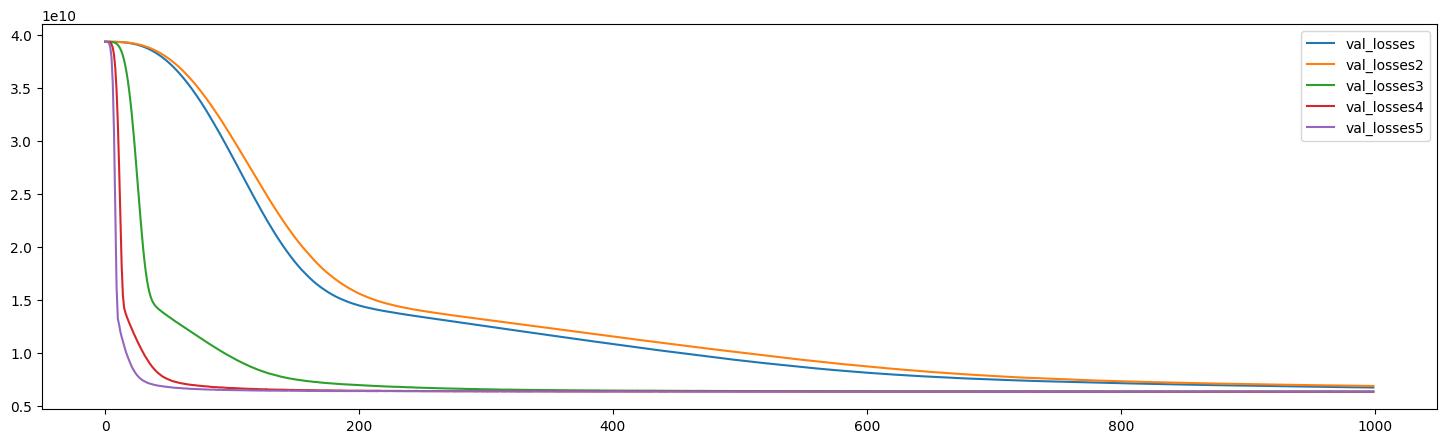

In [121]:
fig, ax = plt.subplots(figsize=(18, 5))
# ax.plot(train_losses, label='train_losses')
# ax.plot(train_losses2, label='train_losses2')
# ax.plot(train_losses3, label='train_losses3')
# ax.plot(train_losses4, label='train_losses4')
# ax.plot(train_losses5, label='train_losses5')
ax.plot(val_losses, label='val_losses')
ax.plot(val_losses2, label='val_losses2')
ax.plot(val_losses3, label='val_losses3')
ax.plot(val_losses4, label='val_losses4')
ax.plot(val_losses5, label='val_losses5')
ax.legend()
fig.show()

58801.91371468322


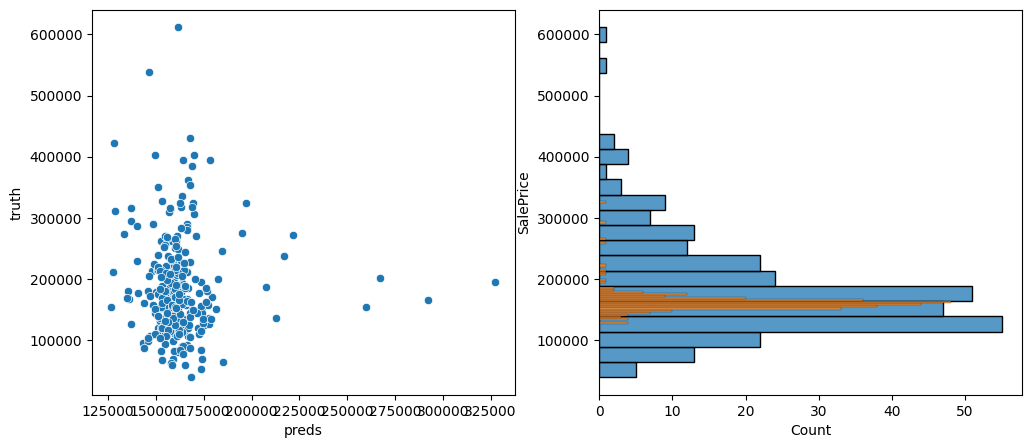

In [126]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
preds = model(torch.tensor(X_val_transformed, dtype=torch.float32)).detach().numpy().ravel()

sns.scatterplot(
    y=y_val, 
    x=np.expm1(preds),
    ax=ax[0]
)
ax[0].set(xlabel="preds", ylabel="truth")
sns.histplot(
    y=y_val,
    ax=ax[1]
)
sns.histplot(
    y=np.expm1(preds),
    ax=ax[1]
)

fig.show()

print(mean_absolute_error(y_val, np.expm1(preds)))

In [154]:
def hook(self:nn.Module, input:torch.Tensor, output:torch.Tensor):
    print(self.__class__.__name__)
    print(type(input))
    print(len(input))
    print(type(output))
    print(output.shape)

linear0_hook_handle = model.linear0.register_forward_hook(hook)

In [153]:
linear0_hook_handle.remove()

In [155]:
model(torch.tensor(X_val_transformed, dtype=torch.float32))

Linear
<class 'tuple'>
1
<class 'torch.Tensor'>
torch.Size([292, 64])


tensor([[12.1248],
        [12.1804],
        [11.9704],
        [11.9256],
        [12.0983],
        [12.0499],
        [11.7487],
        [11.9810],
        [12.0208],
        [11.8290],
        [11.8925],
        [12.0114],
        [11.9819],
        [11.9938],
        [12.2868],
        [11.9353],
        [12.1925],
        [12.0216],
        [11.9364],
        [11.8267],
        [11.9500],
        [11.9648],
        [11.9460],
        [12.0072],
        [11.9916],
        [12.4947],
        [12.0302],
        [12.0680],
        [11.9651],
        [12.0642],
        [12.2685],
        [11.9274],
        [12.0043],
        [11.8718],
        [11.9491],
        [11.9919],
        [11.9750],
        [11.9996],
        [11.9401],
        [11.9449],
        [12.1143],
        [12.0227],
        [12.0232],
        [11.9338],
        [12.0230],
        [12.0008],
        [12.0159],
        [11.9839],
        [11.9599],
        [11.7660],
        [12.0535],
        [11.9840],
        [11.

In [19]:
class BaseNN(nn.Module):
    def __init__(self, input_size, ):
        super(BaseNN, self).__init__()
        self.linear1 = nn.Linear(input_size, 32)
        self.linear2 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = nn.ReLU()(self.linear1(x))
        x = self.linear2(x)
        return x

In [39]:
nnet = NNetRegressor(
    model_class=BaseNN,
    metrics={
        "mse": mean_squared_error,
        "mae": mean_absolute_error, 
        "mape" : mean_absolute_percentage_error
    },
    verbose=True,
)

In [40]:
nn_pipe = Pipeline(steps=[
    ('dropper', NullDropper()),
    ('preprocessor', imputer_encoder),
    ("predictor", nnet)
])

nn_pipe

Pipeline(steps=[('dropper', NullDropper()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x163d0b790>)])),
                ('predictor',
                 NNetRegressor(metrics={'mae': <function mean_absolute_error at 0x14d227e20>,
                                        'mape': <function mean_absolute_percentage_error at 0x14d2540e0>,
                                        'mse': <function mean_squared_error at 0x14d254220>},
                               model_class=<class '__main__.BaseNN'>,
                               verbose=True))])

In [65]:
nnet = NNetRegressor(
    model_class=BaseNN,
    metrics={
        "mse": mean_squared_error,
        "mae": mean_absolute_error, 
        "mape" : mean_absolute_percentage_error
    },
    epochs=1000,
    val_set=(X_val_transformed, y_val.values),
    verbose=True,
)

nnet.fit(X_train_transformed, y_train)

Epoch 1/1000 - Loss: 38965514240.0000 - Train metrics: mse: 38965522432.0000, mae: 180690.4062, mape: 1.0000 - Val Loss: 39333556224.0000 - Val Metrics: mse: 39333564416.0000, mae: 181842.3125, mape: 1.0000
Epoch 11/1000 - Loss: 38952148992.0000 - Train metrics: mse: 38951051264.0000, mae: 180653.4219, mape: 0.9998 - Val Loss: 39319756800.0000 - Val Metrics: mse: 39318900736.0000, mae: 181804.3594, mape: 0.9997
Epoch 21/1000 - Loss: 38901133312.0000 - Train metrics: mse: 38891950080.0000, mae: 180512.1406, mape: 0.9989 - Val Loss: 39266951168.0000 - Val Metrics: mse: 39259013120.0000, mae: 181659.0312, mape: 0.9988
Epoch 31/1000 - Loss: 38815457280.0000 - Train metrics: mse: 38793920512.0000, mae: 180274.5000, mape: 0.9974 - Val Loss: 39178383360.0000 - Val Metrics: mse: 39159869440.0000, mae: 181414.9375, mape: 0.9972
Epoch 41/1000 - Loss: 38702784512.0000 - Train metrics: mse: 38665543680.0000, mae: 179961.2969, mape: 0.9954 - Val Loss: 39062016000.0000 - Val Metrics: mse: 3903014502

NNetRegressor(epochs=1000,
              metrics={'mae': <function mean_absolute_error at 0x14d227e20>,
                       'mape': <function mean_absolute_percentage_error at 0x14d2540e0>,
                       'mse': <function mean_squared_error at 0x14d254220>},
              model_class=<class '__main__.BaseNN'>,
              val_set=(array([[-7.69835621e-01,  1.51068649e+00, -1.41863779e+00, ...,
        -8.95177212e-02,  2.13248035e+00,  1.35573818e-01],
       [-7....
       107000, 350000, 125000, 136500, 236000, 252000, 430000, 130250,
       325000, 132500, 170000, 129900,  58500, 151000, 325000, 209500,
       208900,  84000, 135500, 130000, 202665, 107000,  67000, 166000,
       317000, 110500, 316600, 149700, 131500,  87000, 151400, 110000,
       145000,  78000, 253293, 184000, 165150, 282922, 175000, 220000,
       162900, 169000, 103600, 274000, 315500, 188000, 142953, 140000,
       290000, 104000, 152000, 190000])),
              verbose=True)

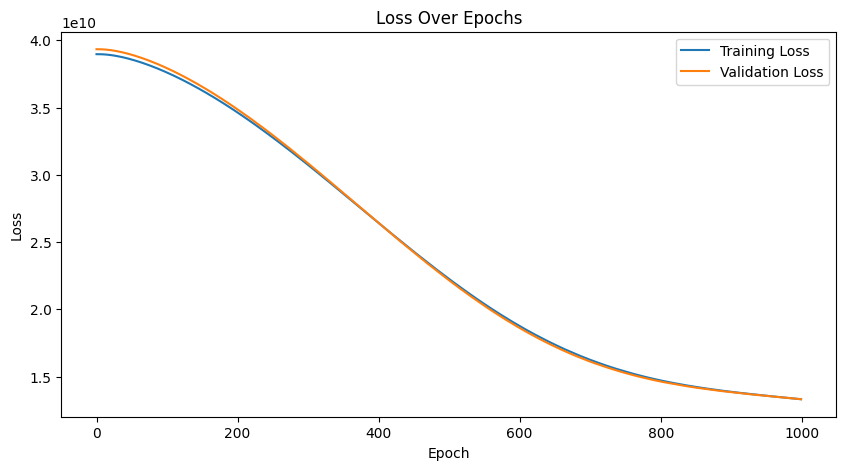

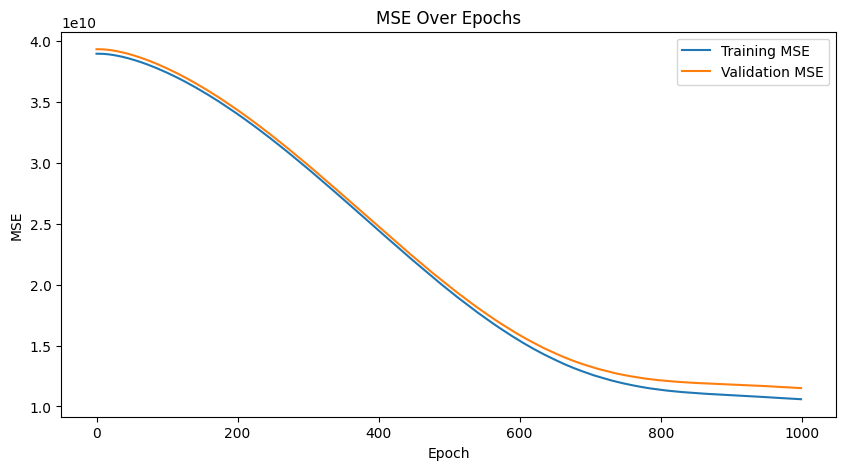

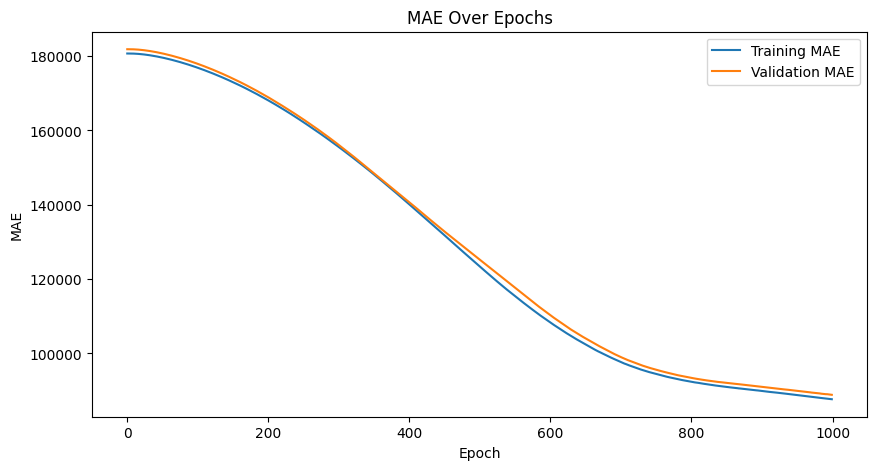

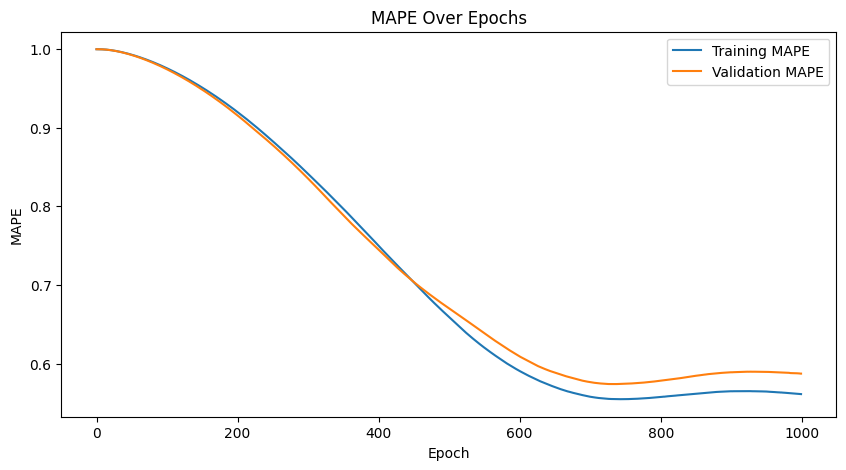

In [66]:
nnet.plot_loss()
nnet.plot_metrics()

In [69]:
trans_target_nnet = TransformedTargetRegressor(
    regressor=NNetRegressor(
        model_class=BaseNN,
        metrics={
            "mse": mean_squared_error,
            "mae": mean_absolute_error, 
            "mape" : mean_absolute_percentage_error
        },
        epochs=1000,
        val_set=(X_val_transformed, y_val.values),
        verbose=True,
    ),
    func=np.log1p,
    inverse_func=np.expm1
)

trans_target_nnet.fit(X_train_transformed, y_train)

Epoch 1/1000 - Loss: 128.7504 - Train metrics: mse: 128.8248, mae: 11.3364, mape: 0.9425 - Val Loss: 39333449728.0000 - Val Metrics: mse: 39333462016.0000, mae: 181842.0156, mape: 1.0000
Epoch 11/1000 - Loss: 9.2075 - Train metrics: mse: 9.1951, mae: 2.4712, mape: 0.2057 - Val Loss: 39329734656.0000 - Val Metrics: mse: 39329693696.0000, mae: 181831.8125, mape: 0.9999
Epoch 21/1000 - Loss: 3.0439 - Train metrics: mse: 2.9793, mae: 1.3527, mape: 0.1126 - Val Loss: 39329464320.0000 - Val Metrics: mse: 39329427456.0000, mae: 181831.0469, mape: 0.9999
Epoch 31/1000 - Loss: 1.7872 - Train metrics: mse: 1.7305, mae: 1.0152, mape: 0.0846 - Val Loss: 39329406976.0000 - Val Metrics: mse: 39329378304.0000, mae: 181830.9062, mape: 0.9999
Epoch 41/1000 - Loss: 1.2162 - Train metrics: mse: 1.1686, mae: 0.8335, mape: 0.0695 - Val Loss: 39329382400.0000 - Val Metrics: mse: 39329357824.0000, mae: 181830.8281, mape: 0.9999
Epoch 51/1000 - Loss: 0.8889 - Train metrics: mse: 0.9065, mae: 0.7407, mape: 0.0

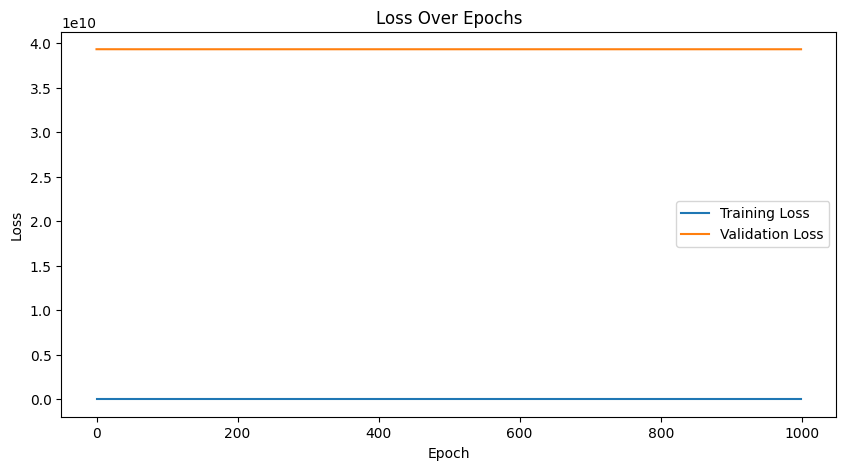

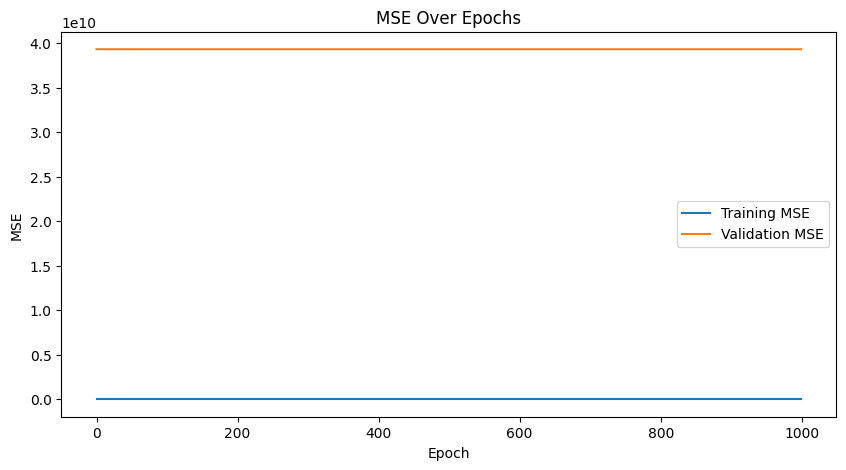

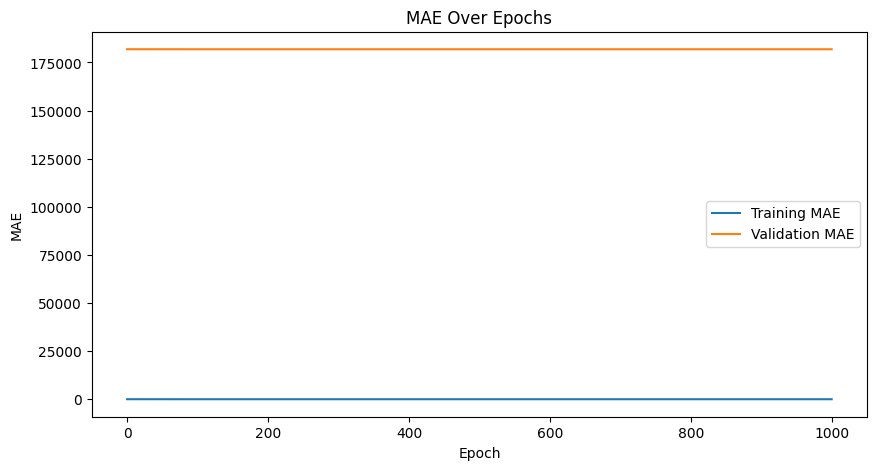

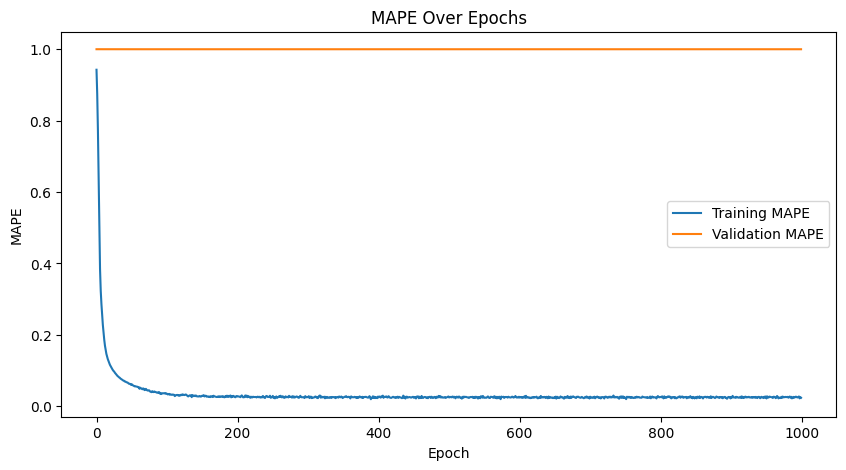

In [72]:
trans_target_nnet.regressor_.plot_loss()
trans_target_nnet.regressor_.plot_metrics()

In [74]:
cross_val_predict(
    estimator=nnet,
    X=X_train_transformed,
    y=y_train
)

Epoch 1/1000 - Loss: 38733426688.0000 - Train metrics: mse: 38733414400.0000, mae: 180330.6406, mape: 1.0000 - Val Loss: 39333568512.0000 - Val Metrics: mse: 39333556224.0000, mae: 181842.3438, mape: 1.0000
Epoch 11/1000 - Loss: 38725177344.0000 - Train metrics: mse: 38724263936.0000, mae: 180307.7656, mape: 0.9999 - Val Loss: 39325007872.0000 - Val Metrics: mse: 39324200960.0000, mae: 181818.8125, mape: 0.9998
Epoch 21/1000 - Loss: 38692073472.0000 - Train metrics: mse: 38686347264.0000, mae: 180215.9531, mape: 0.9993 - Val Loss: 39290560512.0000 - Val Metrics: mse: 39285309440.0000, mae: 181724.0312, mape: 0.9992
Epoch 31/1000 - Loss: 38635114496.0000 - Train metrics: mse: 38620418048.0000, mae: 180057.7656, mape: 0.9983 - Val Loss: 39231168512.0000 - Val Metrics: mse: 39217582080.0000, mae: 181560.4688, mape: 0.9982
Epoch 41/1000 - Loss: 38558175232.0000 - Train metrics: mse: 38531129344.0000, mae: 179843.8125, mape: 0.9970 - Val Loss: 39150899200.0000 - Val Metrics: mse: 3912583168

TypeError: linear(): argument 'input' (position 1) must be Tensor, not NoneType